# Fitbit Analyzer
## How I analyzed the data from my Fitbit to improve my overall health
## Bring the Avengers!
## by Yash Soni

https://medium.freecodecamp.org/how-i-analyzed-the-data-from-my-fitbit-to-improve-my-overall-health-a2e36426d8f9

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/learning-stack/Colab-ML-Playbook/blob/master/Fitbit%20Analyzer/Fitbit_Data_Analysis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/learning-stack/Colab-ML-Playbook/blob/master/Fitbit%20Analyzer/Fitbit_Data_Analysis.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>


libraries that will ease our data analysis

In [0]:
import matplotlib
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt # default library for making plots
import seaborn as sns # for making prettier plots!
import datetime
import math

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None) # to see all columns in the pd dataframe
%config InlineBackend.figure_format = 'retina' # for the crispier version of plots for retina screens

matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12.0, 6.0]

## Download and import the Dataset

In [2]:
!wget https://github.com/yashatgit/fitbit-analyzer/blob/master/data/database_main.xls?raw=true

filename = 'database_main.xls?raw=true'

data = pd.read_excel(filename, sheet_name="main", converters= {'Date': pd.to_datetime})
data.set_index(pd.to_datetime(data.Date),inplace=True)

print("Loaded db successfully!")

--2018-12-31 16:07:53--  https://github.com/yashatgit/fitbit-analyzer/blob/master/data/database_main.xls?raw=true
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/yashatgit/fitbit-analyzer/raw/master/data/database_main.xls [following]
--2018-12-31 16:07:58--  https://github.com/yashatgit/fitbit-analyzer/raw/master/data/database_main.xls
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yashatgit/fitbit-analyzer/master/data/database_main.xls [following]
--2018-12-31 16:07:58--  https://raw.githubusercontent.com/yashatgit/fitbit-analyzer/master/data/database_main.xls
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.git

## Building new columns and sanitising the data
Firstly we will be removing the activity where there were no steps recorded. For sleep data, we will clear out rows where there was no "Deep Sleep" entries

In [0]:
dayCodes = ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
minDayCodes = ['', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

days = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}

def is_nan(x):
    return (x is np.nan or x != x)

def defineSleepBucket(row):
    sleepEntry = row['Sleep Start time']
    if not is_nan(sleepEntry):
        sleepTimeO = datetime.datetime.strptime(sleepEntry, '%Y-%m-%dT%H:%M:%S.000').time()        
        if sleepTimeO.minute > 30:
            return (sleepTimeO.hour + 1)
            #return '{}:{}'.format(str((sleepTimeO.hour + 1)), '00')
        elif sleepTimeO.minute > 0:
            return sleepTimeO.hour + 0.5
            #return '{}:{}'.format(str(sleepTimeO.hour), ':30')
    else:
        return np.nan
    
def defineAwakeBucket(row):
    awakeEntry = row['Sleep End time']
    if not is_nan(awakeEntry):
        awakeEntryO = datetime.datetime.strptime(awakeEntry, '%Y-%m-%dT%H:%M:%S.000').time()        
        if awakeEntryO.minute > 30:
            return (awakeEntryO.hour + 1)
            #return '{}:{}'.format(str((awakeEntryO.hour + 1)), '00')
        elif awakeEntryO.minute > 0:
            return awakeEntryO.hour + 0.5
            #return '{}:{}'.format(str(awakeEntryO.hour), ':30')
    else:
        return np.nan    

#remove all entries where there was no steps recorded. i.e no activity
data = data[data['Steps'].notnull()]

data['Day Label'] = data['Day of Week'].apply(lambda x: days[x])
data['Active exercise'] = data['Minutes Very Active'] > 40

#Build additional Sleep columns
data['Sleep Bucket'] = data.apply(defineSleepBucket, axis=1)
data['Awake Bucket'] = data.apply(defineAwakeBucket, axis=1)

data['% Awake'] = 100 - (data['% Deep sleep'] + data['% REM sleep'] + data['% Light sleep'])
data['% Restorative sleep'] = data['% Deep sleep'] + data['% REM sleep']
data['Restorative sleep mins'] = data['Minutes Deep sleep'] + data['Minutes REM sleep']

#remove all entries where there was no Deep sleep recorded
sleepData = data[data['% Deep sleep'].notnull()]

In [4]:
print("Contains {} records ranging from {} to {}".format(str(len(data)), str(data.iloc[0]['Date']), str(data.iloc[-1]['Date'])))
print('Contains {} entries of Sleep data'.format(len(sleepData)))

data.head()

Contains 116 records ranging from 2018-06-24 00:00:00 to 2018-10-17 00:00:00
Contains 76 entries of Sleep data


,Date,Day of Week,Is Weekday,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Sleep Start time,Sleep End time,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep,Day Label,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-24,2018-06-24,7,False,True,1996,1690,3367,3.01,0.00,59.0,0,1377,47,2,14,362,-1,11.0,133.10892,14.0,89.20880,0.0,0.0,446.51352,284.0,92.0,379.0,0.0,2018-06-24T22:17:00.000,2018-06-25T05:28:30.000,431.0,56.0,2.0,244.0,26.0,79.0,6.0,52.0,25.0,13.0,57.0,19.0,Sun,False,22.5,5.5,11.0,32.0,135.0
2018-06-25,2018-06-25,1,True,False,2863,1685,8394,5.55,36.58,58.0,12,709,244,42,14,1361,-1,2.0,12.40518,94.0,514.11279,0.0,0.0,2311.92765,1326.0,95.0,333.0,0.0,2018-06-25T22:49:30.000,2018-06-26T05:16:30.000,387.0,75.0,3.0,214.0,27.0,44.0,7.0,54.0,30.0,20.0,56.0,12.0,Mon,False,23.0,5.5,12.0,32.0,119.0
2018-06-26,2018-06-26,2,True,False,3398,1683,13569,9.68,24.38,57.0,8,687,231,33,102,2004,-1,10.0,103.59112,187.0,1245.54876,0.0,0.0,2034.05724,1232.0,89.0,351.0,0.0,2018-06-26T22:25:30.000,2018-06-27T05:07:30.000,402.0,53.0,3.0,223.0,28.0,75.0,7.0,51.0,29.0,14.0,56.0,19.0,Tue,True,22.5,5.5,11.0,33.0,128.0
2018-06-27,2018-06-27,3,True,False,3442,1682,13337,9.33,33.53,57.0,11,665,243,30,100,2035,-1,11.0,114.28908,217.0,1310.46804,0.0,0.0,1986.03570,1187.0,97.0,365.0,0.0,2018-06-27T22:36:30.000,2018-06-28T05:24:00.000,407.0,66.0,4.0,197.0,32.0,102.0,10.0,42.0,32.0,17.0,49.0,26.0,Wed,True,23.0,5.5,8.0,43.0,168.0
2018-06-28,2018-06-28,4,True,False,1701,1682,559,0.36,18.29,57.0,6,1025,8,0,0,25,-1,0.0,0.00000,0.0,0.00000,0.0,0.0,403.96356,329.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thu,False,NaN,NaN,NaN,NaN,NaN


Let's take a quick glance how does does the numbers behave on weekdays vs weekends

In [5]:
dayGroupedData = data.groupby(['Day of Week']).mean()
dayTypeGroupedData = data.groupby(['Is Weekday']).mean()

dayTypeGroupedData

,Day of Week,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Is Weekday,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,6.515152,1.0,2679.545455,1667.606061,8789.909091,5.716061,33.527879,61.666667,11.000000,943.090909,215.515152,20.181818,26.272727,1222.242424,-1.0,7.037037,54.388412,136.666667,659.956047,0.074074,0.950886,1774.602004,1025.777778,95.380952,376.450000,0.0,414.428571,73.150000,3.400,219.250000,28.900000,84.050000,7.650000,51.900000,28.850000,17.750000,51.750000,19.750000,0.272727,16.452381,7.333333,10.750000,37.500000,157.200000
True,2.963855,0.0,2742.457831,1610.048193,8127.807229,5.378795,23.098916,61.121622,7.578313,788.963855,176.734940,26.469880,41.626506,1247.108434,-1.0,8.184211,83.742450,146.105263,785.508394,0.789474,10.055665,1739.526390,1089.631579,95.830508,375.535714,0.0,422.423729,73.660714,3.875,222.732143,30.017857,79.142857,7.767857,53.178571,30.892857,17.678571,52.428571,18.964286,0.457831,20.931034,6.456140,10.928571,36.642857,152.803571


In [6]:
data.groupby(['Day of Week']).mean()

,Is Weekday,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Day of Week,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,2766.764706,1679.764706,7474.117647,4.756471,35.142353,61.200000,11.529412,892.235294,197.647059,27.470588,24.470588,1188.058824,-1.0,3.933333,39.324835,147.266667,723.268431,0.000000,0.000000,1884.135575,1165.733333,95.875000,374.200000,0.0,425.812500,68.533333,3.533333,226.200000,29.600000,79.466667,8.133333,52.866667,30.866667,16.466667,53.400000,19.066667,0.117647,23.033333,6.218750,11.066667,35.533333,148.000000
2,1.0,0.0,2932.000000,1613.529412,9709.941176,6.495294,19.542941,60.625000,6.411765,695.588235,192.470588,31.411765,62.705882,1517.058824,-1.0,9.823529,102.797649,160.176471,917.109046,1.058824,13.772624,1782.886879,1125.058824,94.846154,377.416667,0.0,427.538462,72.666667,3.833333,225.333333,29.750000,79.416667,8.000000,52.833333,31.166667,17.583333,52.750000,19.000000,0.705882,21.192308,6.153846,10.666667,36.583333,152.083333
3,1.0,0.0,2848.588235,1611.411765,8856.588235,5.938235,22.770000,60.823529,7.470588,749.647059,179.705882,31.176471,51.411765,1370.058824,-1.0,9.117647,90.933628,153.647059,835.312679,0.823529,10.401669,1620.286221,1010.647059,96.769231,371.230769,0.0,419.615385,75.307692,4.153846,217.384615,30.384615,78.538462,6.923077,48.384615,30.769231,18.384615,52.230769,19.153846,0.705882,19.538462,6.083333,10.230769,37.538462,153.846154
4,1.0,0.0,2695.375000,1604.187500,7546.250000,5.081250,20.955000,61.500000,6.875000,806.750000,166.437500,26.625000,38.187500,1184.937500,-1.0,10.142857,101.458271,150.642857,810.832673,0.571429,6.402520,1711.505051,1085.357143,96.000000,386.363636,0.0,443.636364,83.000000,4.272727,224.454545,31.000000,78.909091,8.181818,57.272727,31.545455,19.181818,51.272727,18.181818,0.437500,21.000000,6.550000,11.363636,37.363636,161.909091
5,1.0,0.0,2449.562500,1536.687500,6948.562500,4.556875,16.574375,61.666667,5.437500,802.437500,144.937500,15.000000,30.500000,954.562500,-1.0,7.615385,81.592786,111.615385,592.829592,1.538462,20.279408,1702.073737,1063.384615,95.500000,362.400000,0.0,369.500000,66.600000,3.400000,216.200000,28.800000,79.600000,7.400000,58.400000,29.200000,16.400000,51.800000,19.800000,0.312500,18.000000,8.333333,12.000000,36.200000,146.200000
6,0.0,1.0,2884.000000,1679.500000,10655.500000,6.877500,43.625000,62.076923,14.312500,955.437500,228.187500,26.875000,36.687500,1424.812500,-1.0,6.538462,55.732043,173.769231,903.743161,0.076923,0.951635,1759.771382,994.000000,95.500000,361.100000,0.0,412.500000,66.600000,3.300000,207.700000,28.400000,86.800000,8.000000,51.400000,27.600000,17.100000,51.200000,20.900000,0.437500,10.900000,8.100000,10.800000,38.000000,153.400000
7,0.0,1.0,2487.117647,1656.411765,7034.058824,4.622941,24.024706,61.285714,7.882353,931.470588,203.588235,13.882353,16.470588,1031.588235,-1.0,7.500000,53.140755,102.214286,433.582299,0.071429,0.950190,1788.373296,1055.285714,95.272727,391.800000,0.0,416.181818,79.700000,3.500000,230.800000,29.400000,81.300000,7.300000,52.400000,30.100000,18.400000,52.300000,18.600000,0.117647,21.500000,6.636364,10.700000,37.000000,161.000000


---
## Utilities

In [0]:
def getDayLabel(dayNum):
    return dayCodes[dayNum]

def plot_heatmap(corrmat, correlationOf, title, darkTheme=False):
    if darkTheme:
        sns.set(style='darkgrid', palette='deep') # Using Seaborn for making heatmap
        cmap="YlGnBu"
    else:     
        sns.set(style = "white")
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corrmat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    plt.figure(figsize=(10, 10))
    hm = sns.heatmap(corrmat, mask=mask, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, cmap=cmap)
    hm.set_title(title)
    plt.yticks(rotation=0)
    plt.show()

---
# Activity Analysis

## 1. Activity summary - Steps, Calories and Floor counts

In [8]:
data[['Calories Burned', 'Steps', 'Minutes Sedentary', 'Minutes Fairly Active', 'Minutes Very Active', 'Cardio minutes', 'Fat Burn minutes', 'Active exercise', 'Resting Heart Rate']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Calories Burned,116.0,2724.560345,653.985218,522.0,2521.75,2877.5,3116.75,4085.0
Steps,116.0,8316.163793,4398.676997,0.0,6295.75,8630.0,11275.00,25570.0
Minutes Sedentary,116.0,832.810345,309.649982,0.0,682.75,745.5,1049.25,1440.0
Minutes Fairly Active,116.0,24.681034,20.114714,0.0,4.75,23.0,38.25,78.0
Minutes Very Active,116.0,37.258621,35.085268,0.0,2.00,30.5,64.00,135.0
Cardio minutes,103.0,7.883495,10.061868,0.0,0.00,4.0,13.00,49.0
Fat Burn minutes,103.0,143.631068,91.585917,0.0,74.00,144.0,200.50,517.0
Resting Heart Rate,101.0,61.267327,3.036087,55.0,59.00,62.0,63.00,68.0


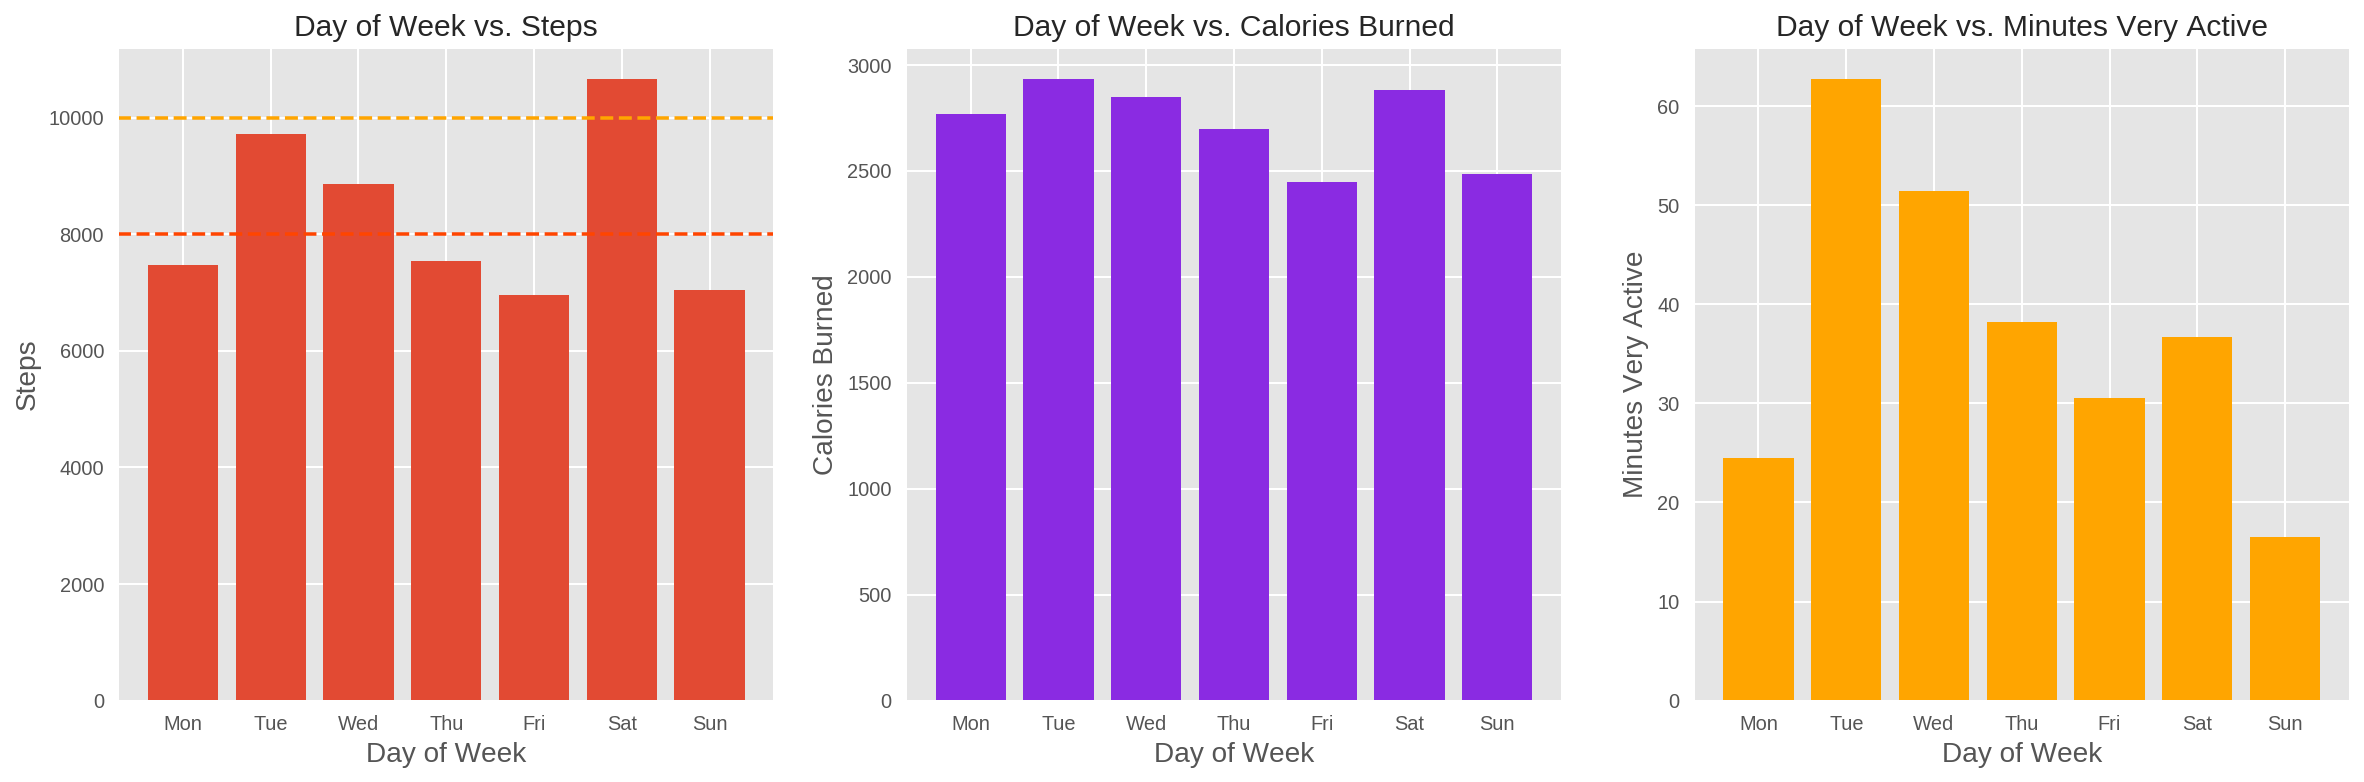

In [9]:
fig = plt.figure(figsize = (20,6))

ax = plt.subplot(131)  
plt.bar(dayGroupedData.index, dayGroupedData['Steps'])
plt.title('Day of Week vs. Steps', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Steps', fontsize=14)
ax.axhline(8000, color="orangered", linestyle='--')
ax.axhline(10000, color="orange", linestyle='--')
ax.set_xticklabels(minDayCodes)

#############

ax2 = fig.add_subplot(132)
plt.bar(dayGroupedData.index, dayGroupedData['Calories Burned'], color='blueviolet')
plt.title('Day of Week vs. Calories Burned', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Calories Burned', fontsize=14)
ax2.set_xticklabels(minDayCodes)

#############

ax3 = fig.add_subplot(133)
ax3.set_xticklabels(minDayCodes)
plt.bar(dayGroupedData.index, dayGroupedData['Minutes Very Active'], color='orange')
plt.title('Day of Week vs. Minutes Very Active', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Minutes Very Active', fontsize=14)
plt.show()

Not fussing on the daily calorie burn, I had kept a goal of attaining 8000 steps count each day on my Fitbit device. The graphs below suggested I am averaging about ~7800 steps per day which is a quite close to my goal. There are some studies which suggest hitting 10000 steps per day is ideal and that shall be the next target.

Tuesdays to Saturdays were the days where I averaged about 40 minutes of very active minutes - which simply translates to active exercise. Fewer minutes on Sundays were due to purely due to laziness/recovery time. The drop in active minutes on Mondays proves that I am falling for the Monday Blues and guess it's time to fix that 💪🏼

## 2. Sedentary minutes

Text(0.5,1,'"Sedentary minutes" per day')

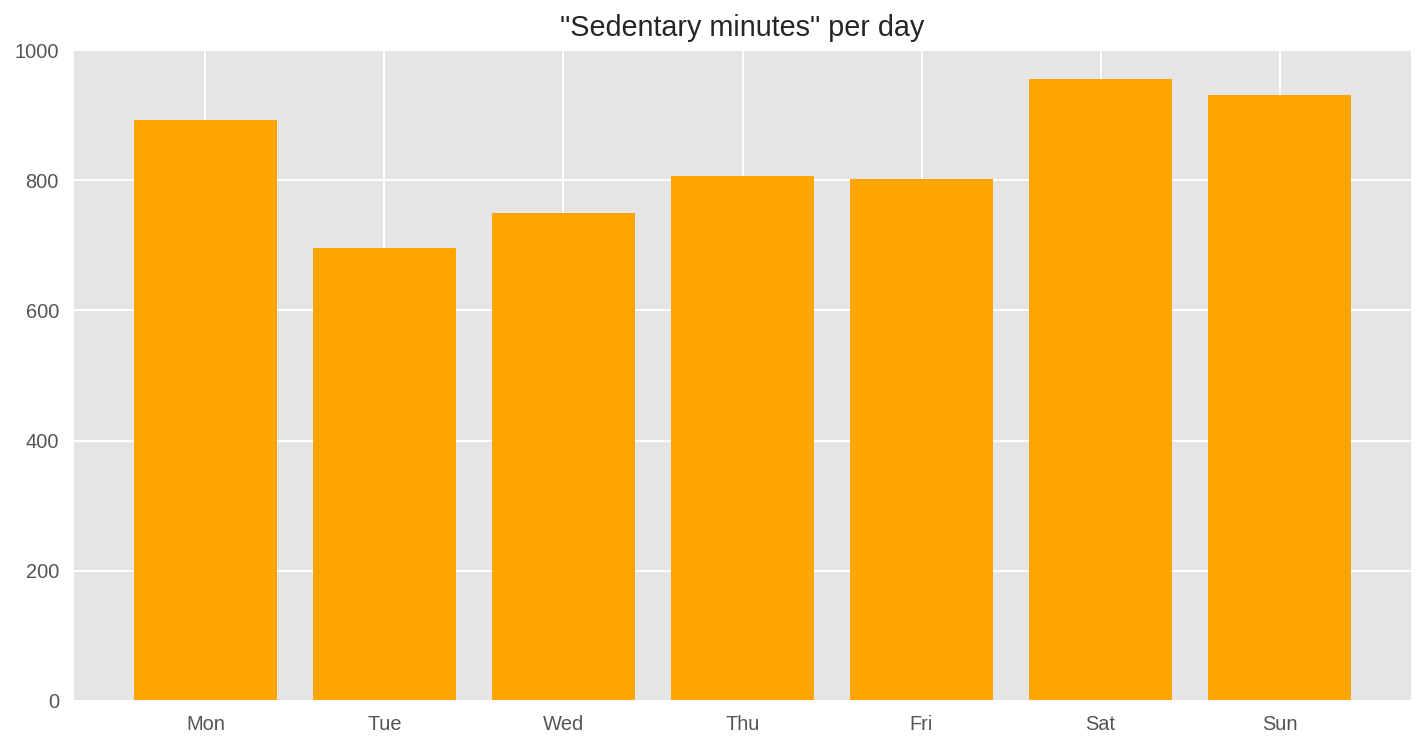

In [10]:
plt.bar(dayGroupedData.index, dayGroupedData['Minutes Sedentary'], color='orange', tick_label=minDayCodes[1:])
plt.title('"Sedentary minutes" per day')

## Average heart rate / calorie burn rate per min / vs exercise type

Analysing the amount of calories burned per minutes for various Activities shows some interesting findings. Though there is a lot of similar data available on internet, it is very difficult to generalise these numbers for everyone. Since, lot of this depends on the fitness levels, demographics, skillset and most importantly how much I enjoy doing some specific exercises.

,Time,avgBPM,maxBPM,Calories burned,Steps,Cal/Min
Activity Type,,,,,,
Fitbit Coach,10.000000,131.0,149.0,86.000000,5.0,8.600000
Running,9.000000,149.0,183.0,107.000000,1202.0,11.825000
Squash,44.000000,139.0,170.0,427.000000,4366.0,9.704545
Swim,20.333333,0.0,0.0,77.666667,97.0,3.876400
Tennis,35.000000,144.0,176.0,357.000000,2507.0,10.200000
Walk,20.000000,121.0,164.0,182.000000,2239.0,9.100000
Weight training,21.000000,136.0,166.0,203.000000,100.0,9.666667


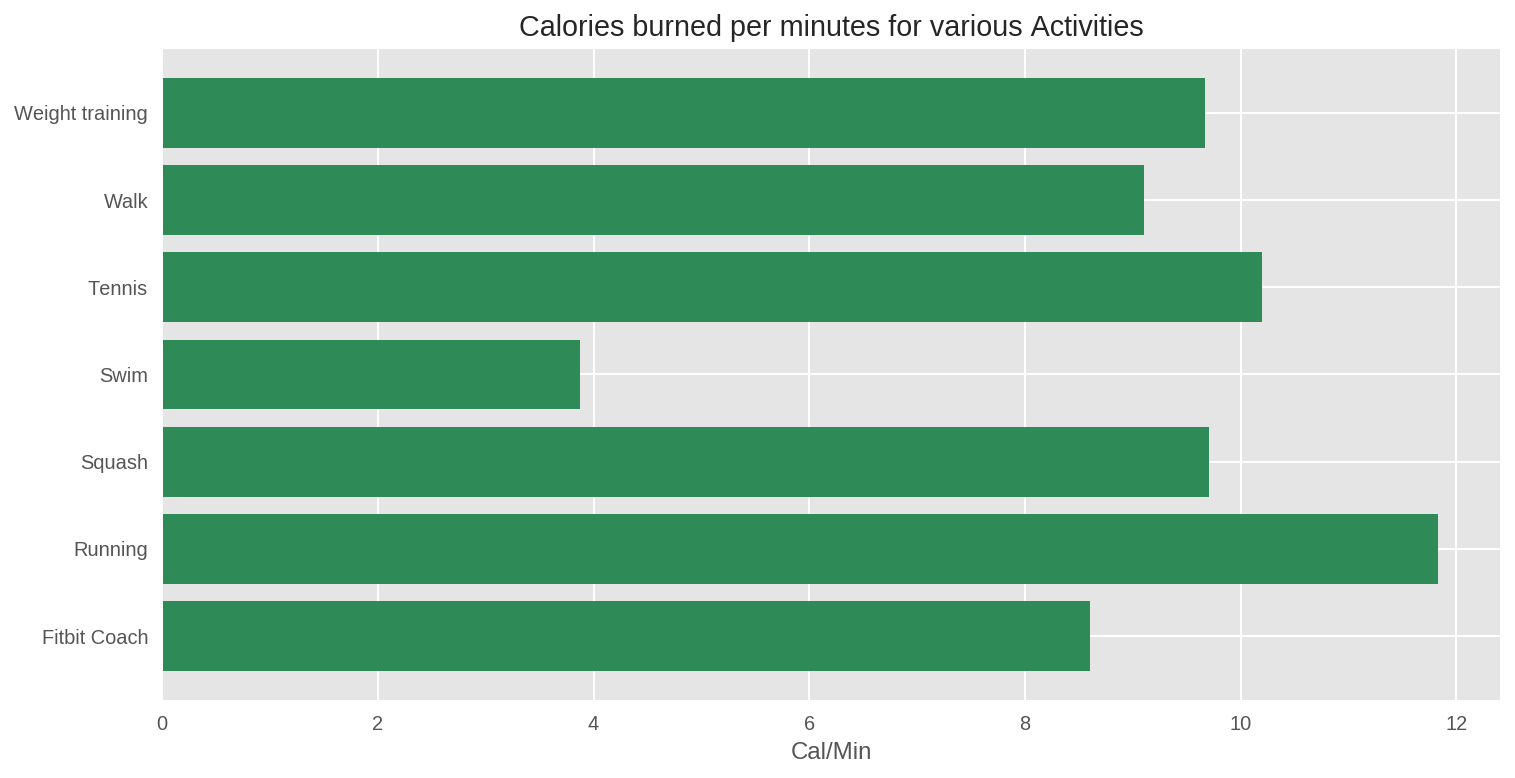

In [11]:
activityDf = pd.read_excel(filename, sheet_name="activities")
#skateboard,badminton, body weight ex, cyclinng
activityDf['Cal/Min'] = activityDf['Calories burned']/activityDf['Time']
groupedActivitiesDf = activityDf.groupby(['Activity Type']).mean()

#Plot Data
plt.barh(groupedActivitiesDf.index, groupedActivitiesDf['Cal/Min'], color='seagreen')
plt.title('Calories burned per minutes for various Activities')
plt.xlabel('Cal/Min')
plt.plot()

groupedActivitiesDf

It is interesting to see that running helps me burn almost 12 calories per minute. The maths is simple, to compensate for a beer, a 10 minutes runs is what I need. 🏃🏻‍+ 🕑 = 🍺

Tennis 🎾 - the favourite activity from the lot - takes the second spot. That's again a win-win scenario! It will be interesting to see if this number changes as I improve my skills.

Swimming numbers were not shocking to me because I am still struggling to keep up with my continuous lap count. And after spending some time in pool, the exercise turns to a leisure activity.

Point to note here is that calories burned should not be the only metric on which these activities can be graded. But, this happens to be the only metric which I can currently measure via Fitbit.

## 3. Calorie burn coorelation

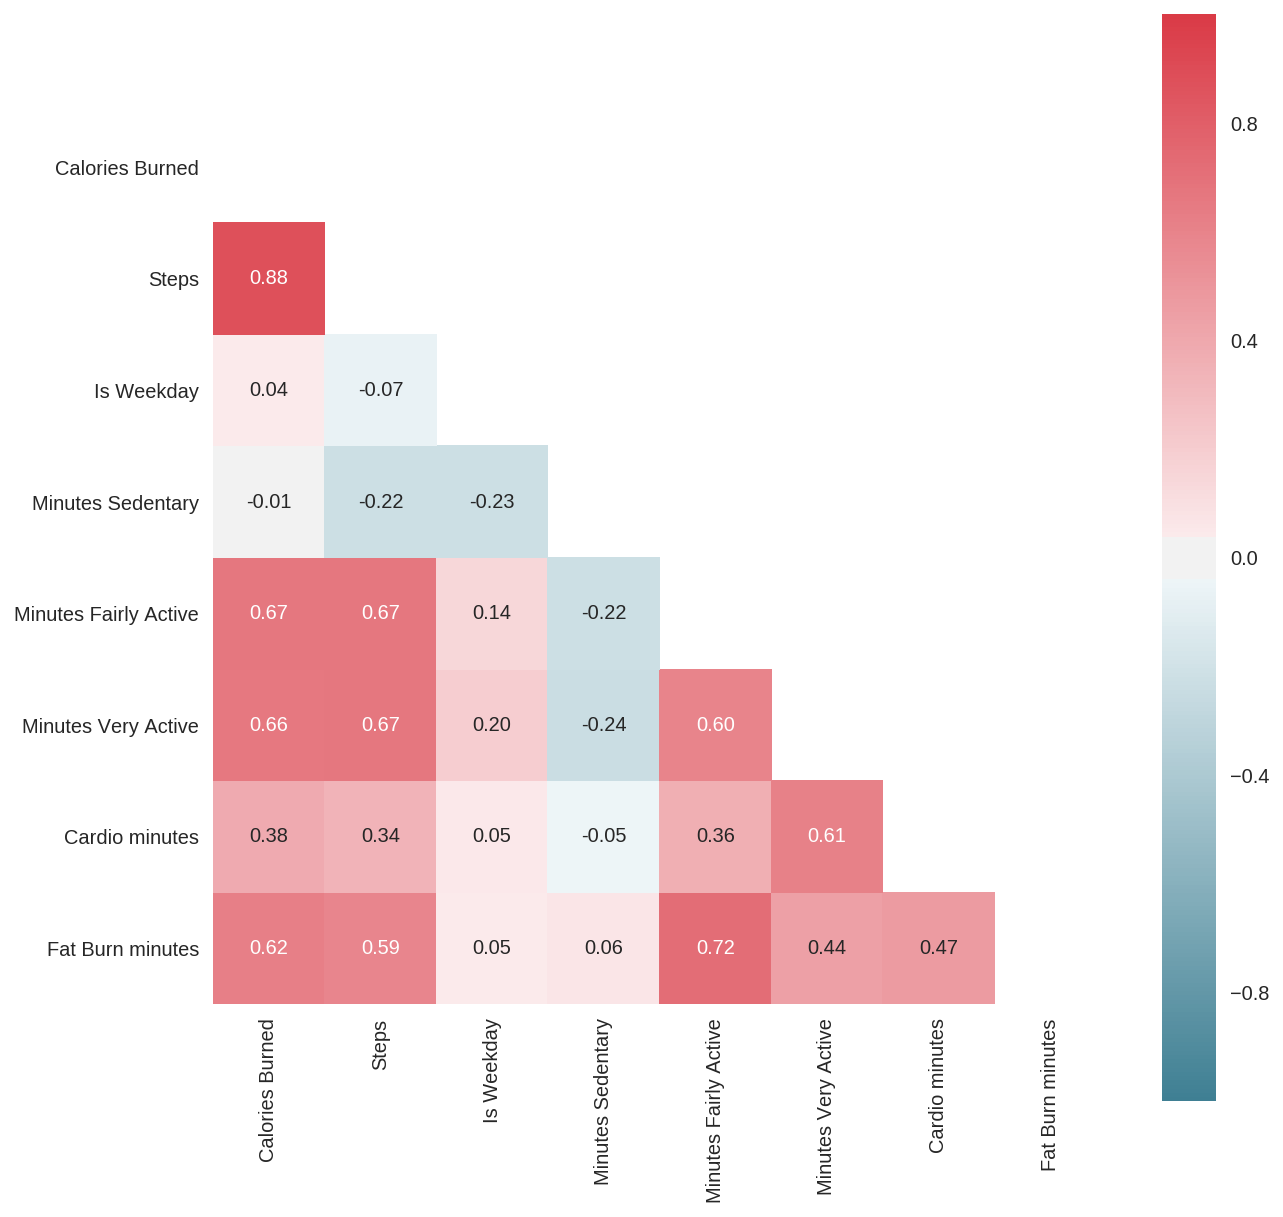

In [12]:
correlationOf = 'Calories Burned'
corrdf_calories = data[['Calories Burned','Steps', 'Is Weekday', 'Minutes Sedentary', 'Minutes Fairly Active', 'Minutes Very Active', 'Cardio minutes', 'Fat Burn minutes']]
plot_heatmap(corrdf_calories.corr(), correlationOf, '')

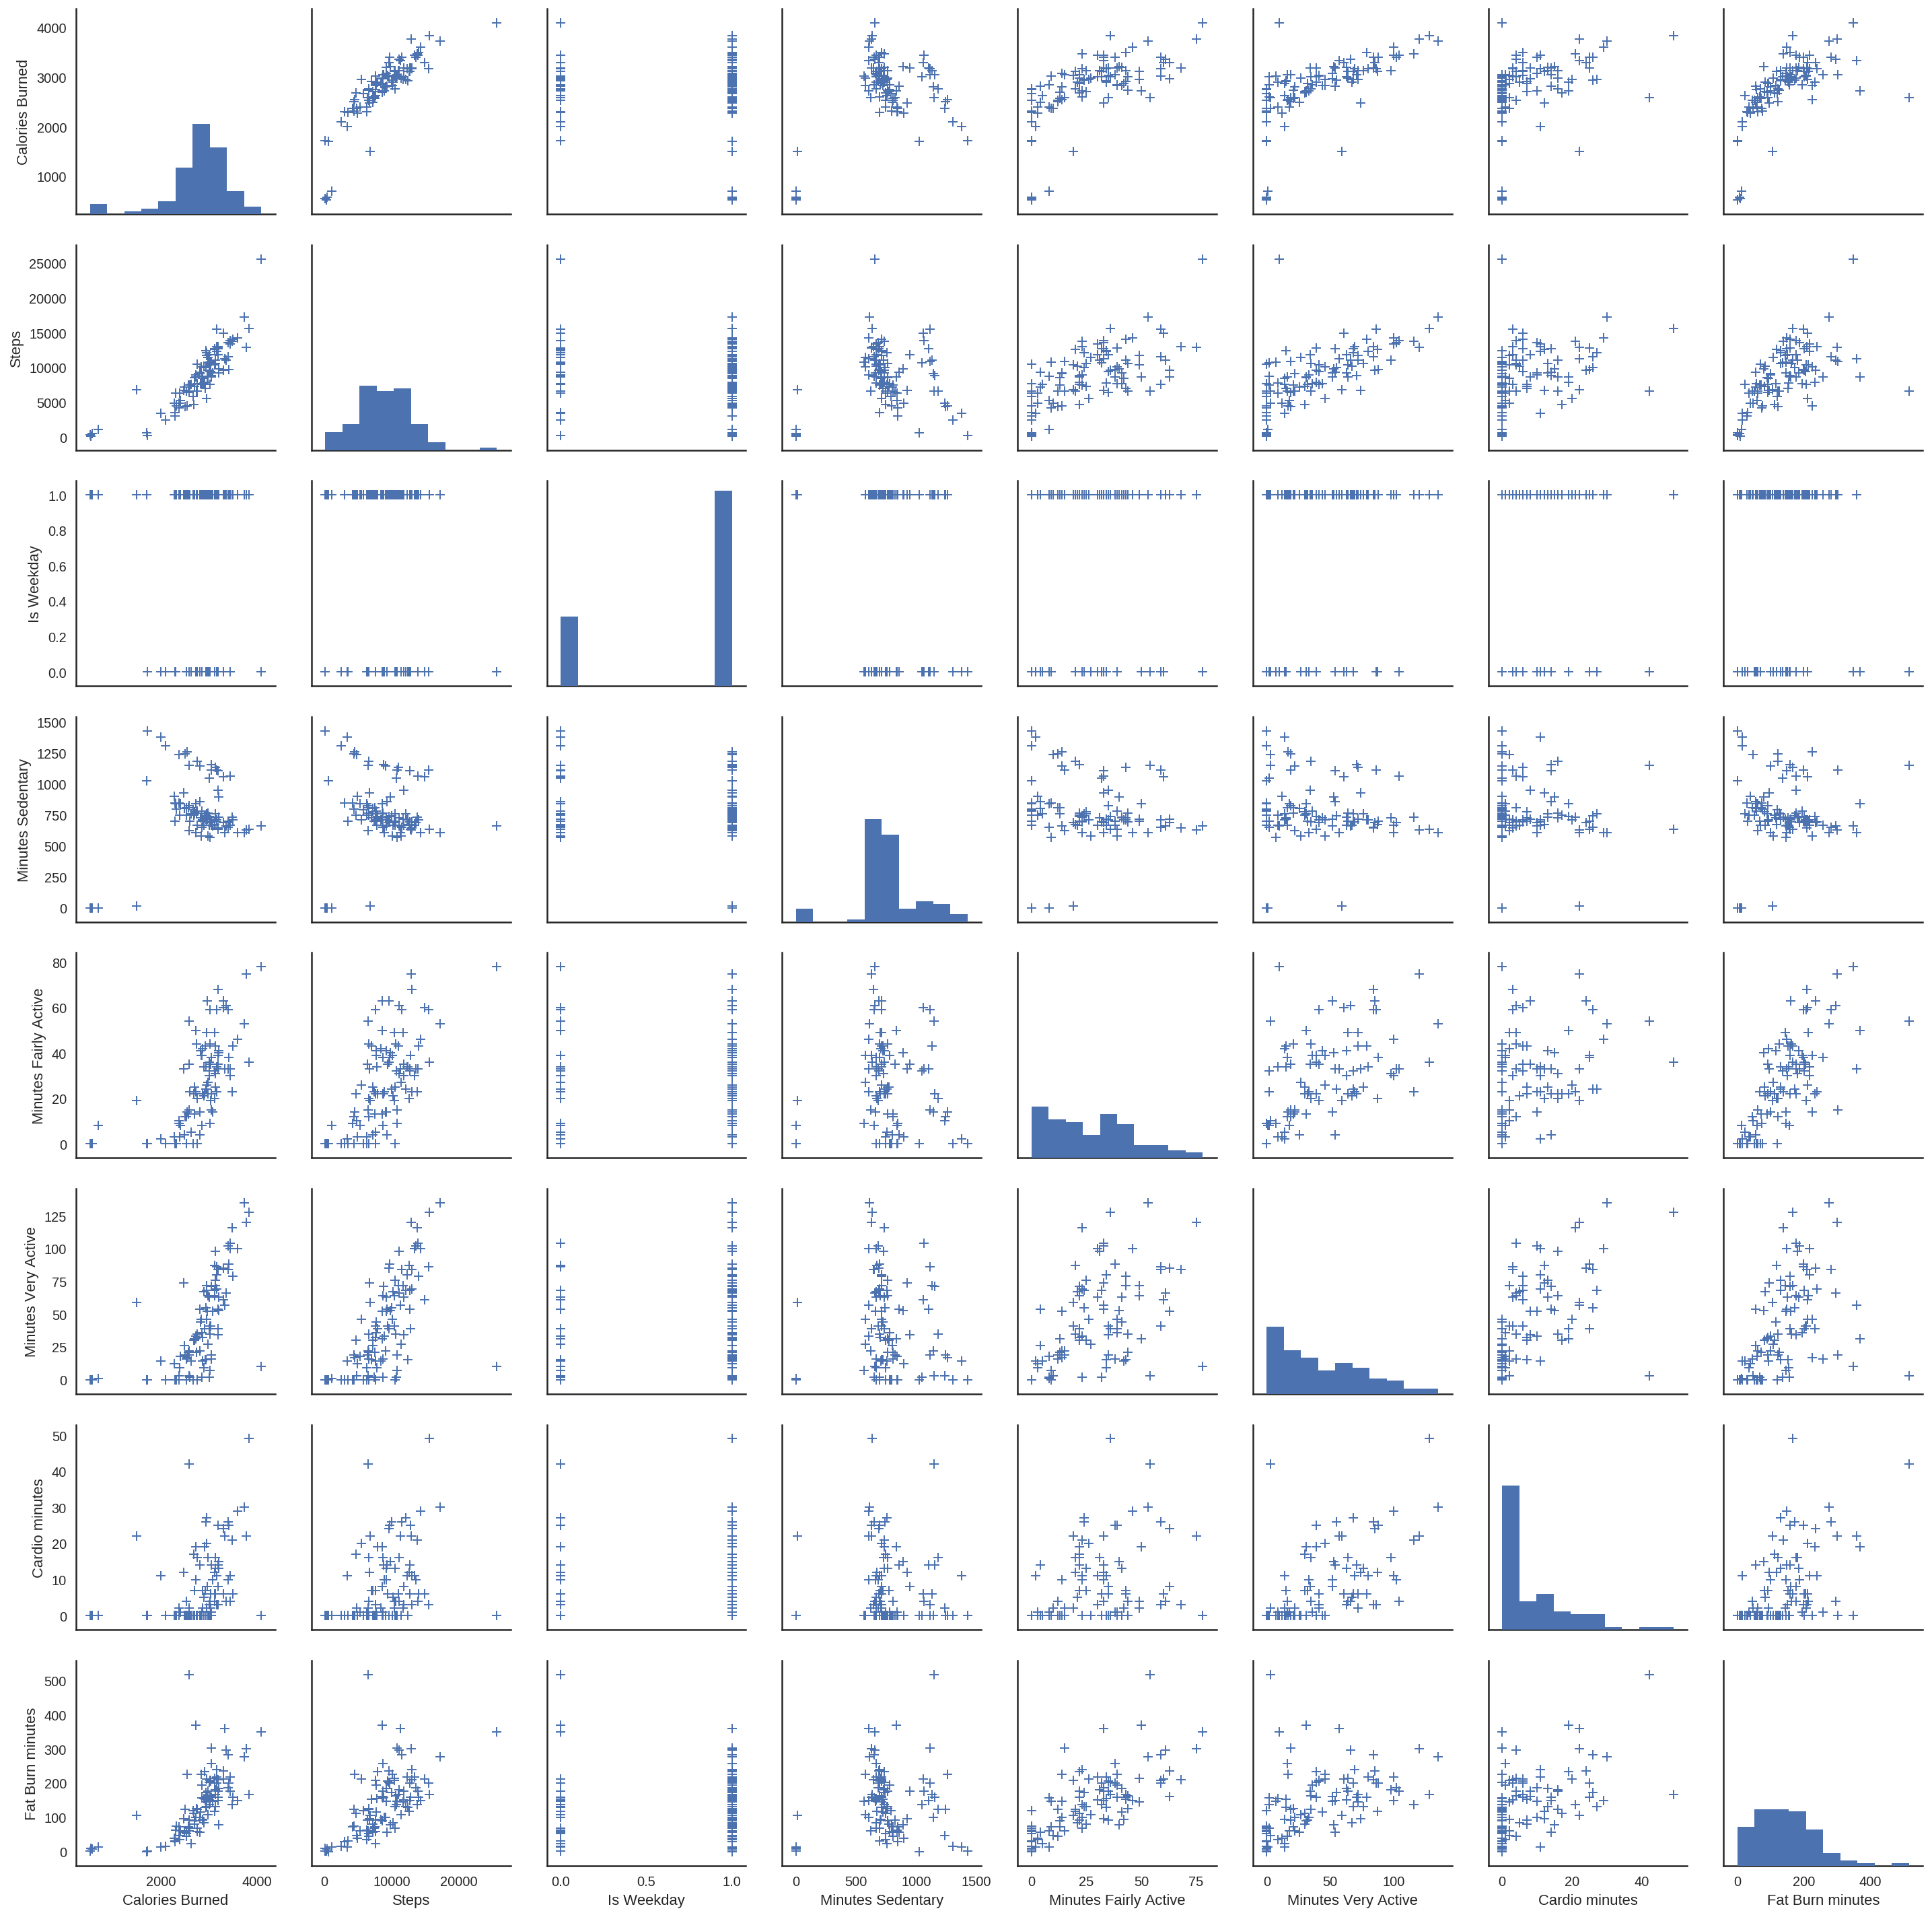

In [13]:
# Basic correlogram
sns.pairplot(corrdf_calories.dropna(), kind="scatter", markers="+", plot_kws=dict(s=50, edgecolor="b", linewidth=1))
plt.show()

The calories burned is strongly related to amount of steps and active minutes. Minutes sedentary has a negative correlation with Weekdays which implies that I spend more time slacking off on weekends.

---
# Sleep Analysis

Sleep is essential to helping maintain mood, memory, and cognitive performance and there is no running from it. We spend about a third of our life in sleeping. That's a staggering 26 years spent sleeping in bed! While metabolism generally slows down, all major organs and regulatory systems continue to function. Hence, it becomes important to get the most out of our sleep.

Reading more on this, I found that there are some standard ways which can help achieve a good night sleep.
* Following a good sleep schedule
* Avoid bright/blue light at night before hitting the bed
* Avoid caffeine later in the day
* Sleep in a cool and dark room
* Getting at-least 7–9 hours of sleep. There are some studies which say that even in 5 hours you can achieve the most out of your sleep.

Over the course of this experiment, I tried to follow the above steps to bind myself to a strict sleep schedule. It was time to validate them.

## 1. How regular is my sleeping habits?

 - Am I getting the required hours of sleep? - Average sleep hours and the deviation
 - Am I following a good sleep schedule? - Average sleep and wake up timings

,count,mean,std,min,25%,50%,75%,max
Time in bed,76.0,7.14364,0.821759,3.65,6.895833,7.225,7.454167,9.566667


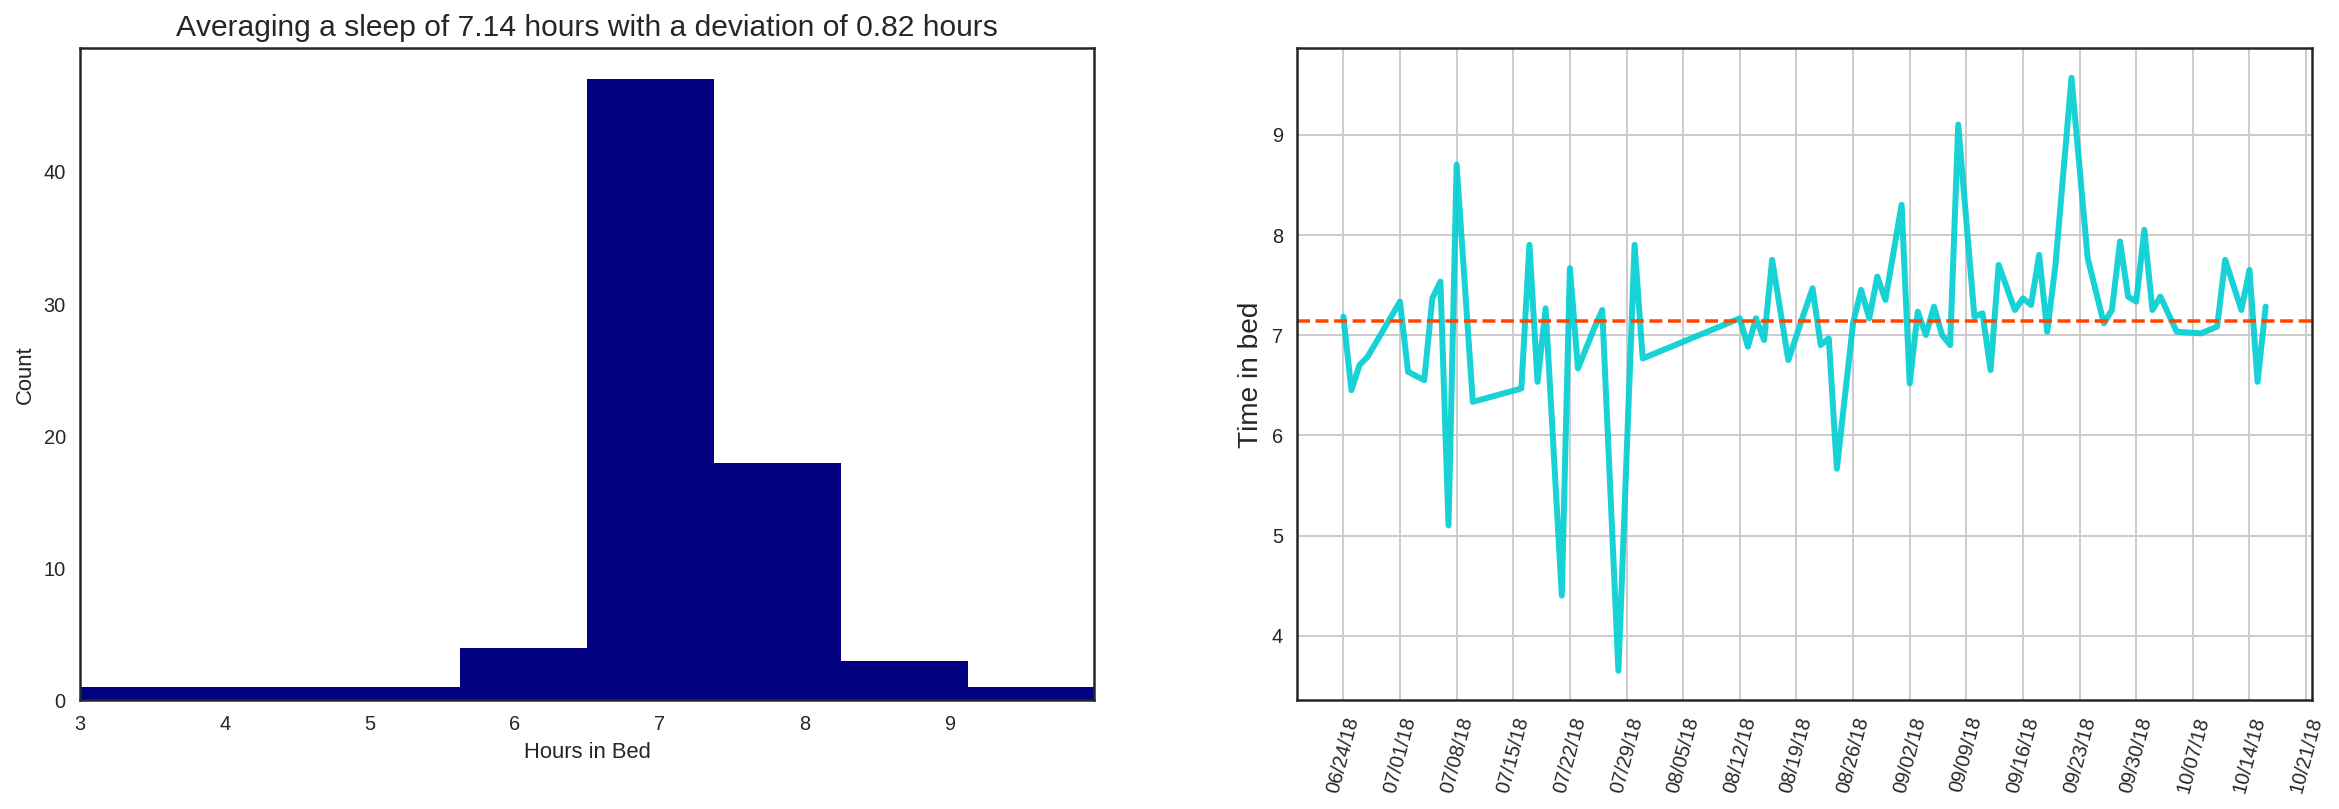

In [14]:
import matplotlib.dates as mdates

sleepDesc = pd.DataFrame(sleepData['Time in bed']/60).describe().transpose()
avgSleepHours = round(sleepDesc.at['Time in bed','mean'],2)
summary = 'Averaging a sleep of {} hours with a deviation of {} hours'.format(avgSleepHours, round(sleepDesc.at['Time in bed','std'],2))
hoursInBed = sleepData['Time in bed']/60

fig = plt.figure(figsize = (20,6))

ax = plt.subplot(121)  
plt.hist(hoursInBed, bins = 8, range = (3, 10), color="navy")
plt.xlim(3, 10)
plt.xticks(range(3, 10))
plt.xlabel('Hours in Bed')
plt.ylabel('Count');
plt.title(summary, fontsize=15)

#############

ax2 = fig.add_subplot(122)
plt.plot(sleepData['Date'],hoursInBed, linestyle='-', 
         markersize=10, color='darkturquoise', label='% Light', linewidth=3.0, alpha=0.9)
plt.ylabel('Time in bed', fontsize=14)
ax2.axhline(avgSleepHours, color="orangered", linestyle='--')
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=6))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
ax2.grid(True)
plt.xticks(rotation=75)
plt.plot()

sleepDesc

As far as behavioral data goes, this is reasonably well-behaved. Notice that this distribution doesn't vary much and is quite steep. The deviation is of less than an hour.

On the other note, according to [National Sleep Foundation](https://www.sleepfoundation.org/how-sleep-works/how-much-sleep-do-we-really-need/page/0/2) I should be getting sleep between 7-9 hours. Looks like barely scratching the mark here! 😅

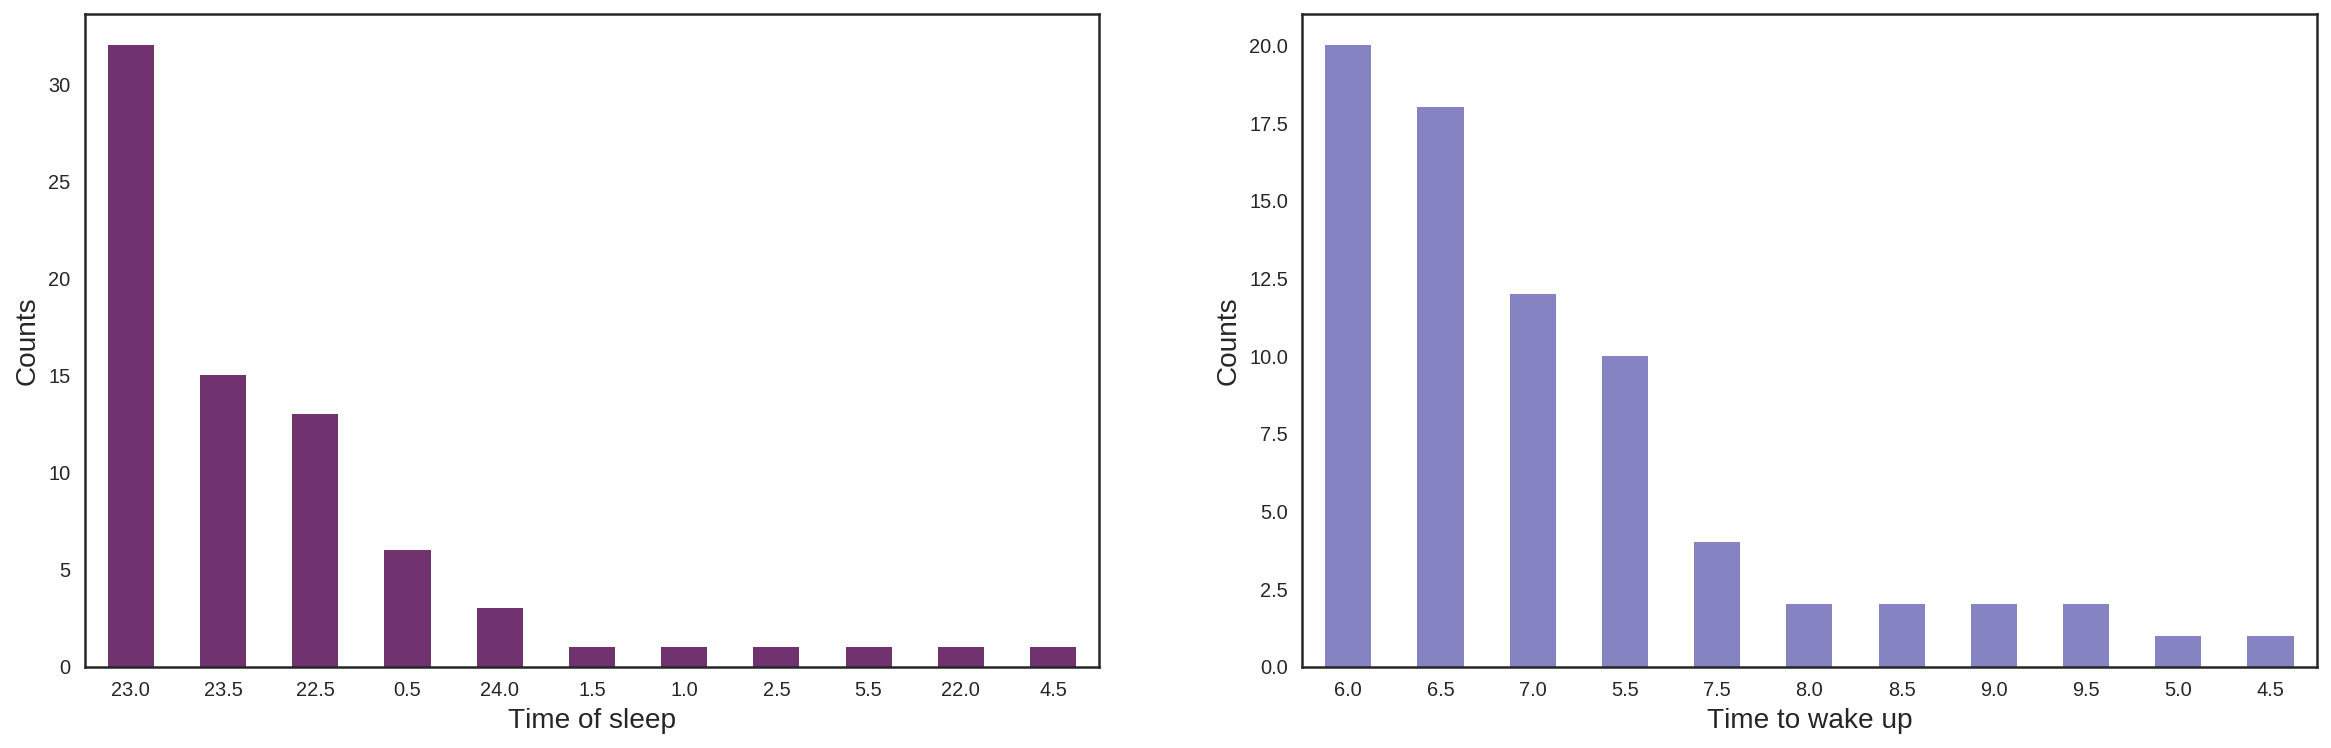

In [15]:
sleepBDF = sleepData[['Sleep Bucket', 'Awake Bucket', 'Time in bed']]
sleepBDF['Time in bed'] = sleepBDF['Time in bed']/60

#sleepBDF.groupby(['Sleep Bucket']).mean()
#sleepBDF.describe().transpose()

## plot the sleep and awake counts
fig = plt.figure(figsize = (20,6))

ax = plt.subplot(121)  
pd.value_counts(sleepData['Sleep Bucket']).plot.bar(cmap="BuPu_r", alpha=0.8)
plt.xlabel('Time of sleep', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=0)

#############

ax2 = fig.add_subplot(122)
pd.value_counts(sleepData['Awake Bucket']).plot.bar(cmap="plasma", alpha=0.5)
plt.xlabel('Time to wake up', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=0)
plt.show()

#https://www.sleepfoundation.org/sleep-tools-tips/healthy-sleep-tips

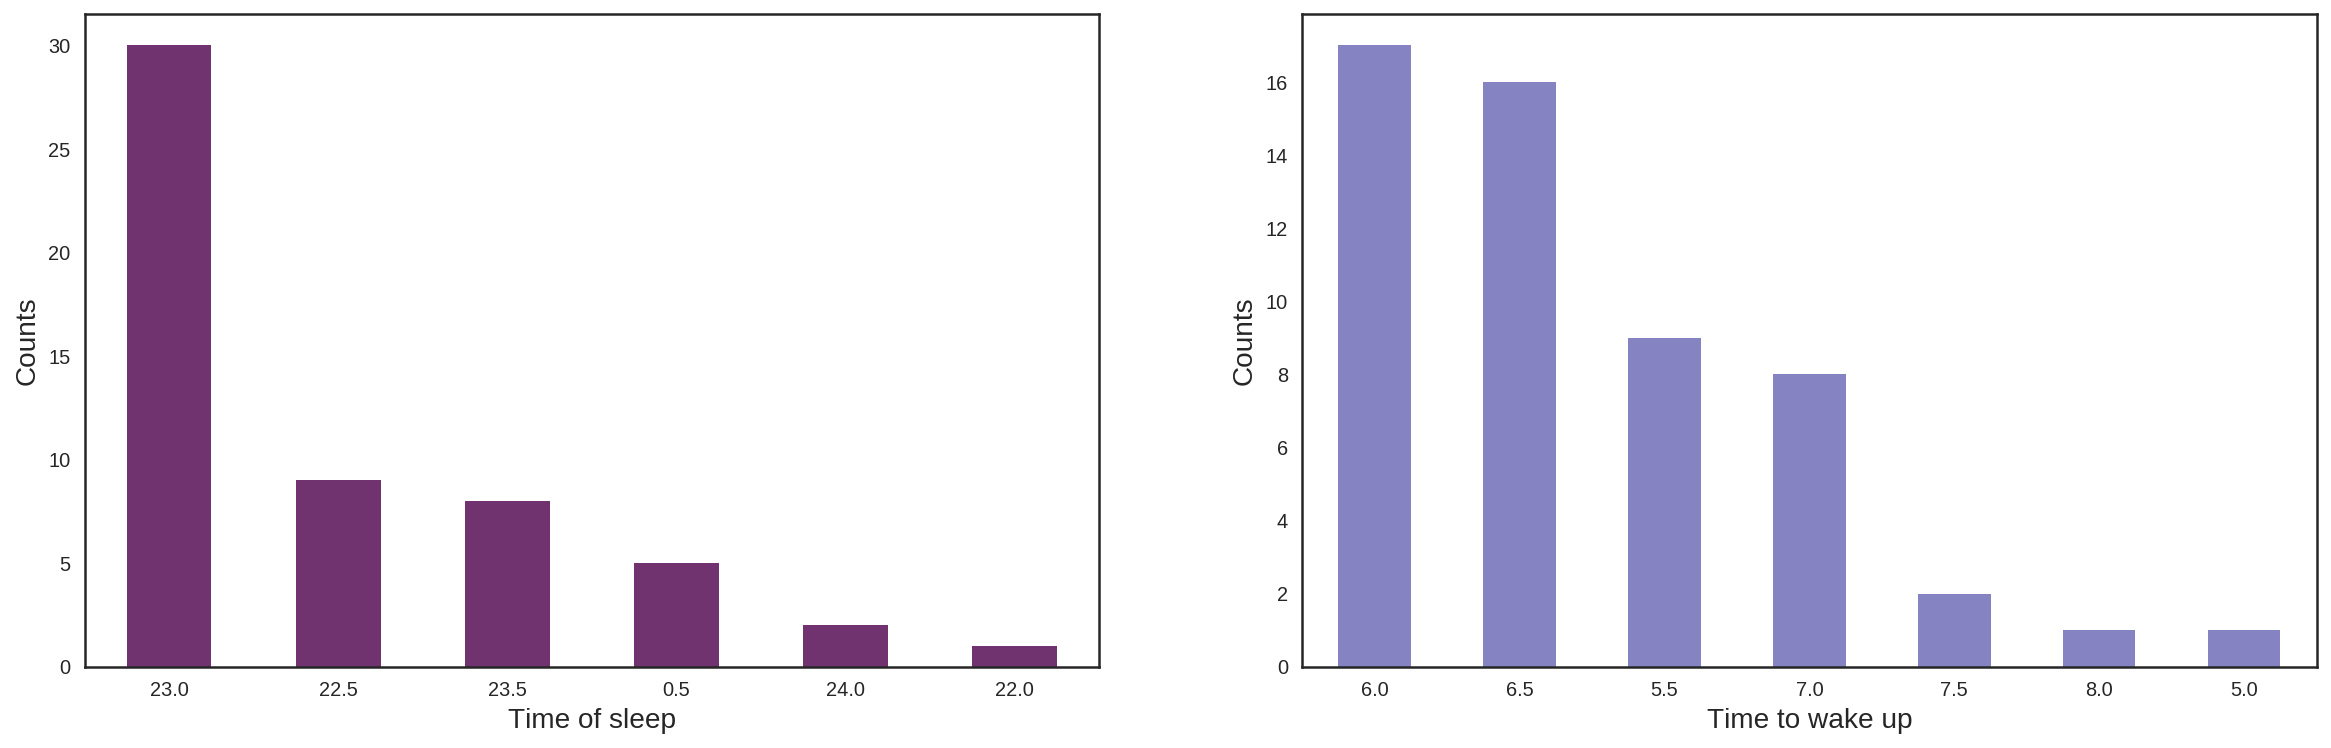

In [16]:
sleepBDF_weekday = sleepData[['Sleep Bucket', 'Awake Bucket', 'Time in bed', 'Is Weekday']]
sleepBDF_weekday['Time in bed'] = sleepBDF_weekday['Time in bed']/60
sleepBDF_weekday = sleepBDF_weekday[sleepBDF_weekday['Is Weekday']]

#sleepBDF.groupby(['Sleep Bucket']).mean()
#sleepBDF.describe().transpose()

## plot the sleep and awake counts
fig = plt.figure(figsize = (20,6))

ax = plt.subplot(121)  
pd.value_counts(sleepBDF_weekday['Sleep Bucket']).plot.bar(cmap="BuPu_r", alpha=0.8)
plt.xlabel('Time of sleep', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=0)

#############

ax2 = fig.add_subplot(122)
pd.value_counts(sleepBDF_weekday['Awake Bucket']).plot.bar(cmap="plasma", alpha=0.5)
plt.xlabel('Time to wake up', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.xticks(rotation=0)
plt.show()

#https://www.sleepfoundation.org/sleep-tools-tips/healthy-sleep-tips

## 2. Types of sleep

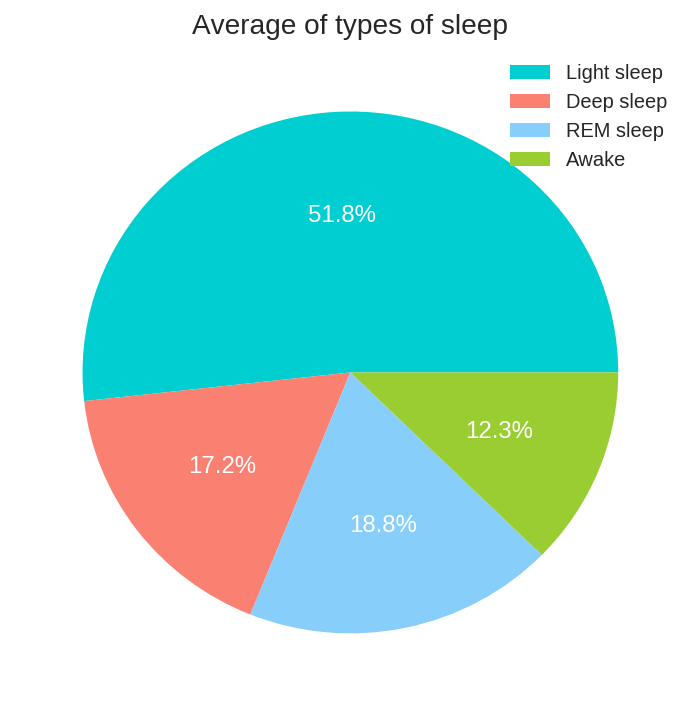

In [17]:
avgSleep = sleepData[['Minutes Light sleep', 'Minutes Deep sleep', 'Minutes REM sleep', 'Minutes Awake']].mean()

fig = plt.figure(figsize = (6,6))
labels=['Light sleep', 'Deep sleep', 'REM sleep', 'Awake']
plt.pie(avgSleep, colors = ['darkturquoise', 'salmon', 'lightskyblue', 'yellowgreen'], autopct='%1.1f%%', labels=labels, textprops=dict(color="w"))

# #carve the donut
# my_circle=plt.Circle( (0,0), 0.7, color='white')
# p=plt.gcf()
# p.gca().add_artist(my_circle)

plt.title('Average of types of sleep', fontsize=14)
plt.legend()
plt.show()

The plot below shows that on an average, my body spends just about 17% in Deep sleep, 19% REM and rest in either light or being slightly awake. The datetime plot of Light and Deep sleep shows that these numbers vary a lot.

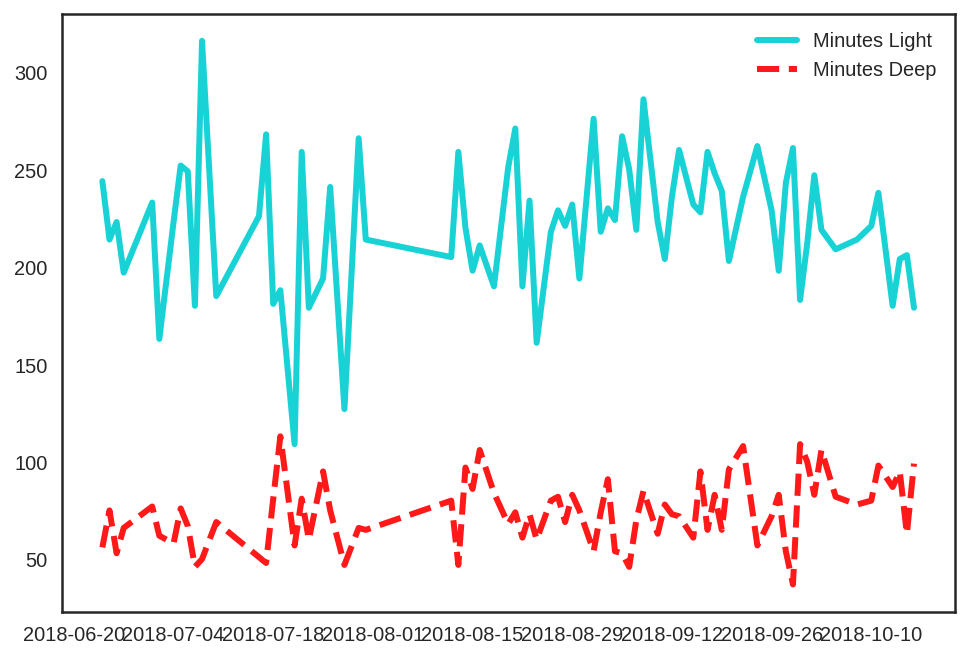

In [18]:
plt.plot(sleepData['Date'],sleepData['Minutes Light sleep'], linestyle='-', 
         markersize=10, color='darkturquoise', label='Minutes Light', linewidth=3.0, alpha=0.9)
plt.plot(sleepData['Date'],sleepData['Minutes Deep sleep'], linestyle='--', 
         markersize=10, color='red', label='Minutes Deep', linewidth=3.0, alpha=0.9)
plt.legend()

## 3. Correlation between amount of sleep and the sleep stages.
Do sleeping more will help me attain more deep or REM sleep?

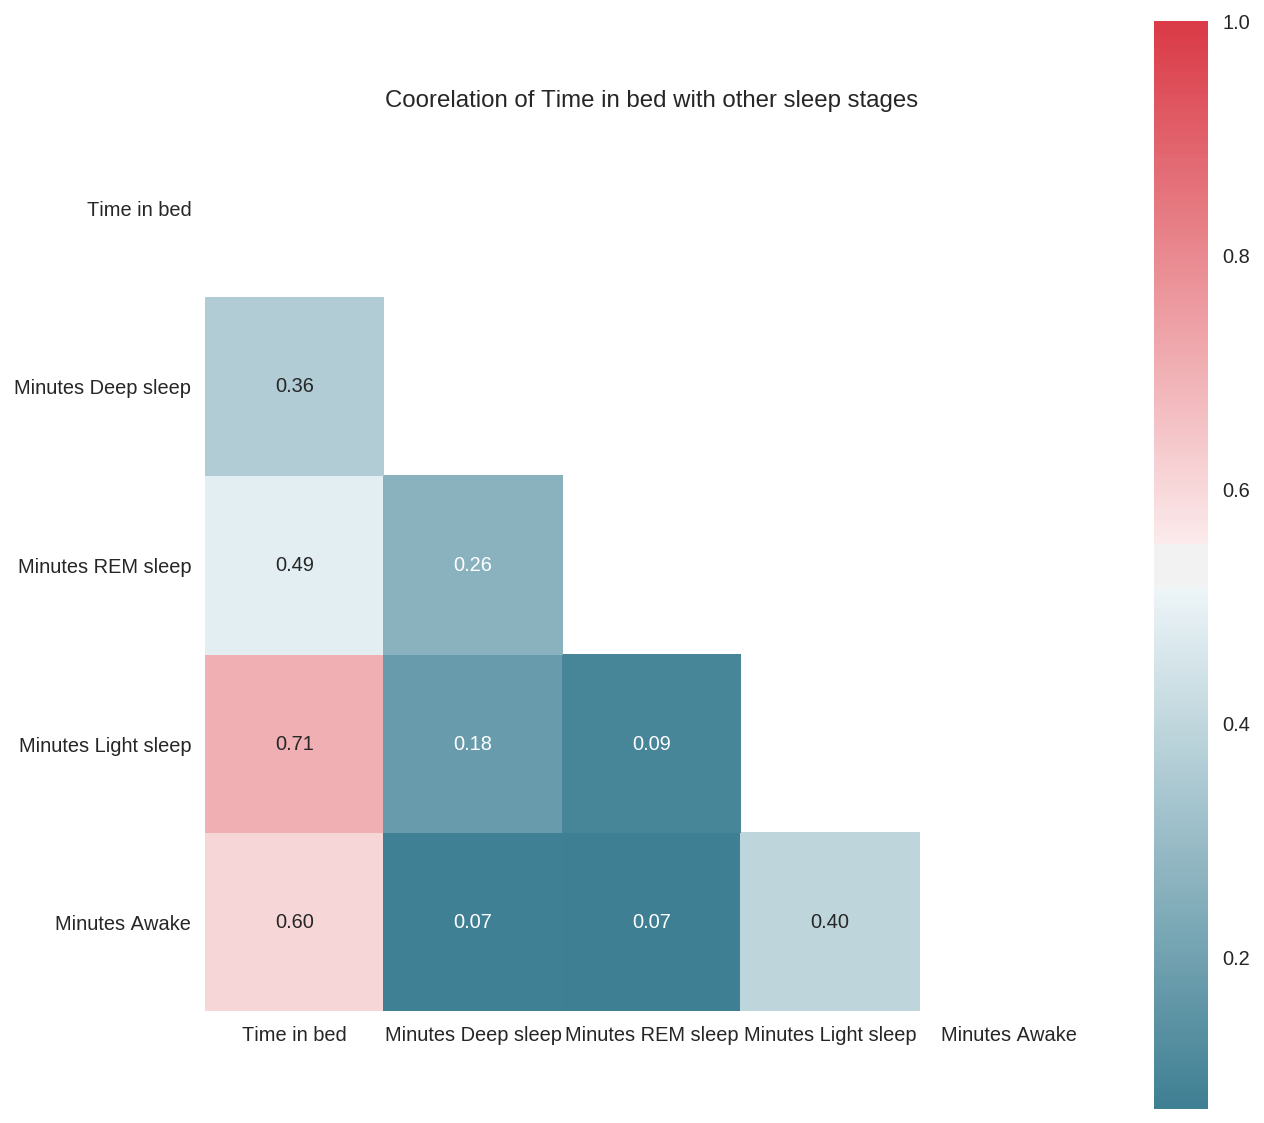

,Time in bed,Minutes Deep sleep,Minutes REM sleep,Minutes Light sleep,Minutes Awake
Time in bed,1.000000,0.363047,0.485731,0.705513,0.604619
Minutes Deep sleep,0.363047,1.000000,0.262515,0.178520,0.074543
Minutes REM sleep,0.485731,0.262515,1.000000,0.092427,0.070540
Minutes Light sleep,0.705513,0.178520,0.092427,1.000000,0.395523
Minutes Awake,0.604619,0.074543,0.070540,0.395523,1.000000


In [19]:
corrdf_sleep_types = sleepData[['Time in bed', 'Minutes Deep sleep', 'Minutes REM sleep', 'Minutes Light sleep', 'Minutes Awake']].corr().abs()
plot_heatmap(corrdf_sleep_types, correlationOf, 'Coorelation of Time in bed with other sleep stages')
corrdf_sleep_types

Notice that the "Deep sleep minutes" are not very coorelated with the time in bed. 
Which shows that sleepinng more doesn't necessarily guarantee a good deep sleep.

## 4. Types of Sleep based on different days

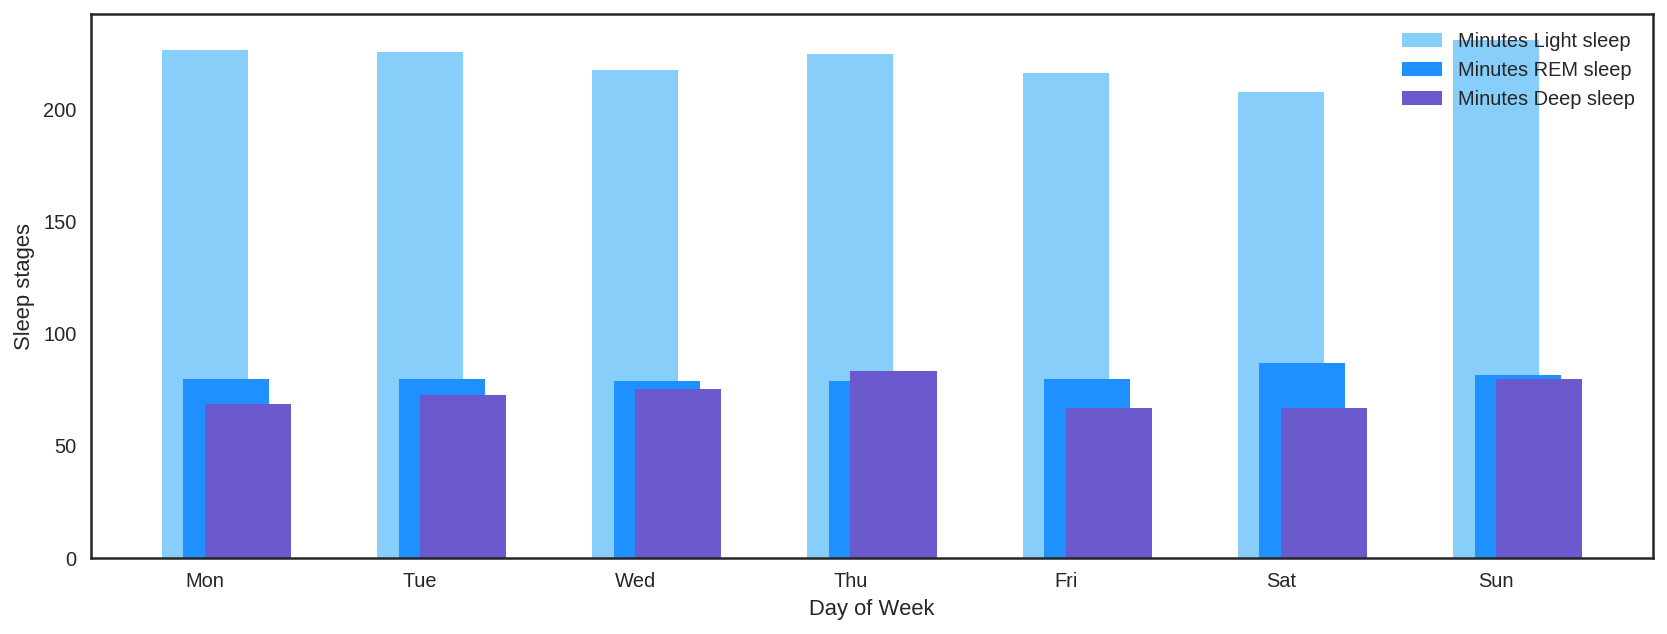

In [20]:
fig = plt.figure(figsize = (14,5))
plt.bar((dayGroupedData.index), dayGroupedData['Minutes Light sleep'],width = 0.4, color='lightskyblue', label="Minutes Light sleep", tick_label=minDayCodes[1:])
plt.bar((dayGroupedData.index + 0.1), dayGroupedData['Minutes REM sleep'], width = 0.4, color='dodgerblue', label="Minutes REM sleep")
plt.bar((dayGroupedData.index + 0.2), dayGroupedData['Minutes Deep sleep'], width = 0.4, color='slateblue', label="Minutes Deep sleep")
plt.xlabel('Day of Week')
plt.ylabel('Sleep stages')
plt.legend()

Let's now look at the different days of the week. Did I sleep more on weekends? (I certainly hope so.) 

## 5. Effect of Sleep on Weekdays 💼 vs Weekends 🎪

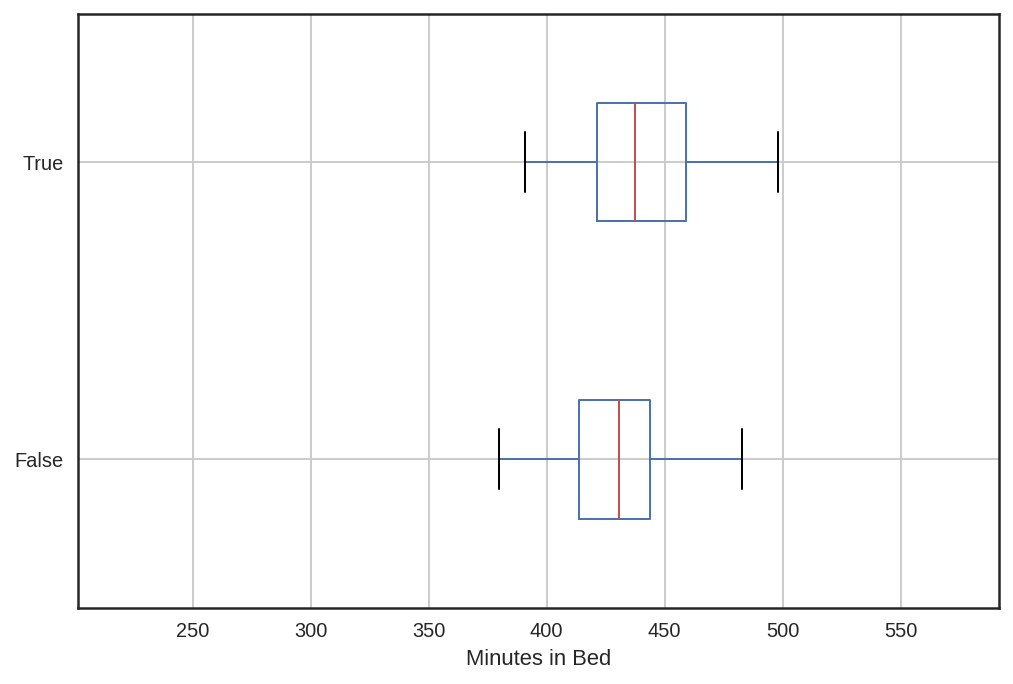

In [21]:
ax = sleepData.boxplot(column = 'Time in bed', by = 'Is Weekend', vert = False, widths = 0.4)
plt.xlabel('Minutes in Bed')
plt.suptitle('')
plt.title('');

The above plot shows that I tend to sleep a bit more on Weekends. The upper whisker is quite high for weekends 
indicatign varying sleep times.

let's check out how does the plots vary for indivisual days of the week.

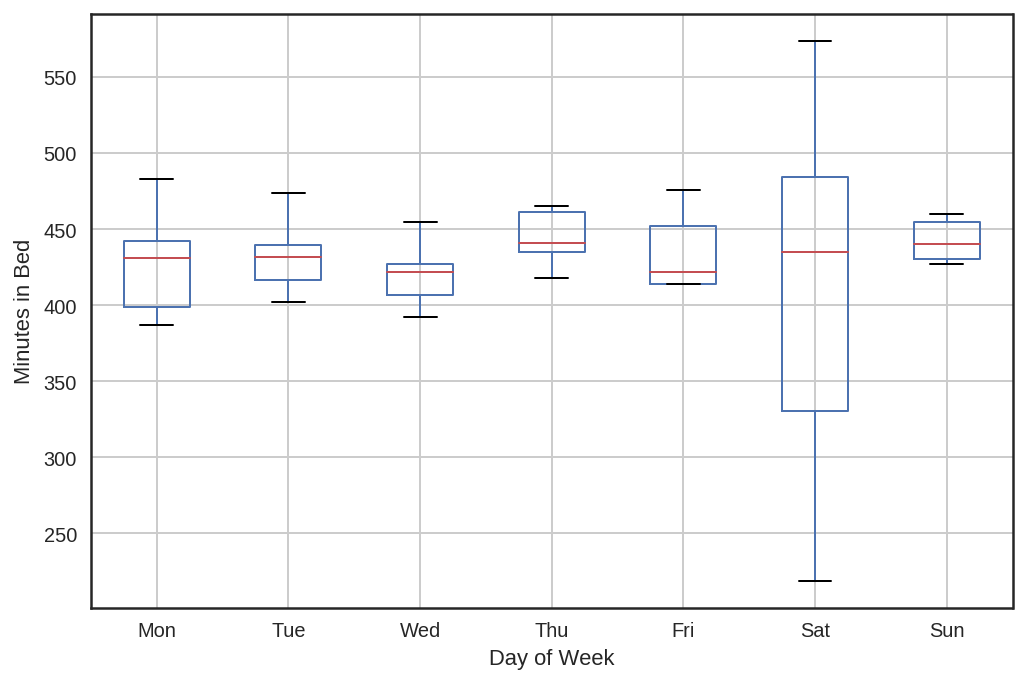

In [22]:
ax = sleepData.boxplot(column = 'Time in bed', by = 'Day of Week')
ax.set_xticklabels(minDayCodes[1:])
plt.ylabel('Minutes in Bed')
plt.suptitle('')
plt.title('');

This is pretty interesting. 
The rest of the days are straighforward with lesser deviations but from the looks of it, I have exploited saturday night sleep for sure! 

## Coorelation of sleep with other activity numbers

In [0]:
sleepData['8 > Sleep > 7'] = sleepData['Time in bed'] > 7*60
sleepData['Sleep > 7'] = sleepData['Time in bed'] > 7*60
sleepData['Sleep > 8'] = sleepData['Time in bed'] > 8*60
sleepData['Active mins > 50'] = sleepData['Minutes Very Active'] > 50
sleepData['Active mins > 60'] = sleepData['Minutes Very Active'] > 60

sleepData['wee'] = np.logical_and(sleepData['Sleep Bucket'] <= 23, sleepData['Awake Bucket'] <= 6.5)
# slept before 11 and woke up by 6:30
#sleepData

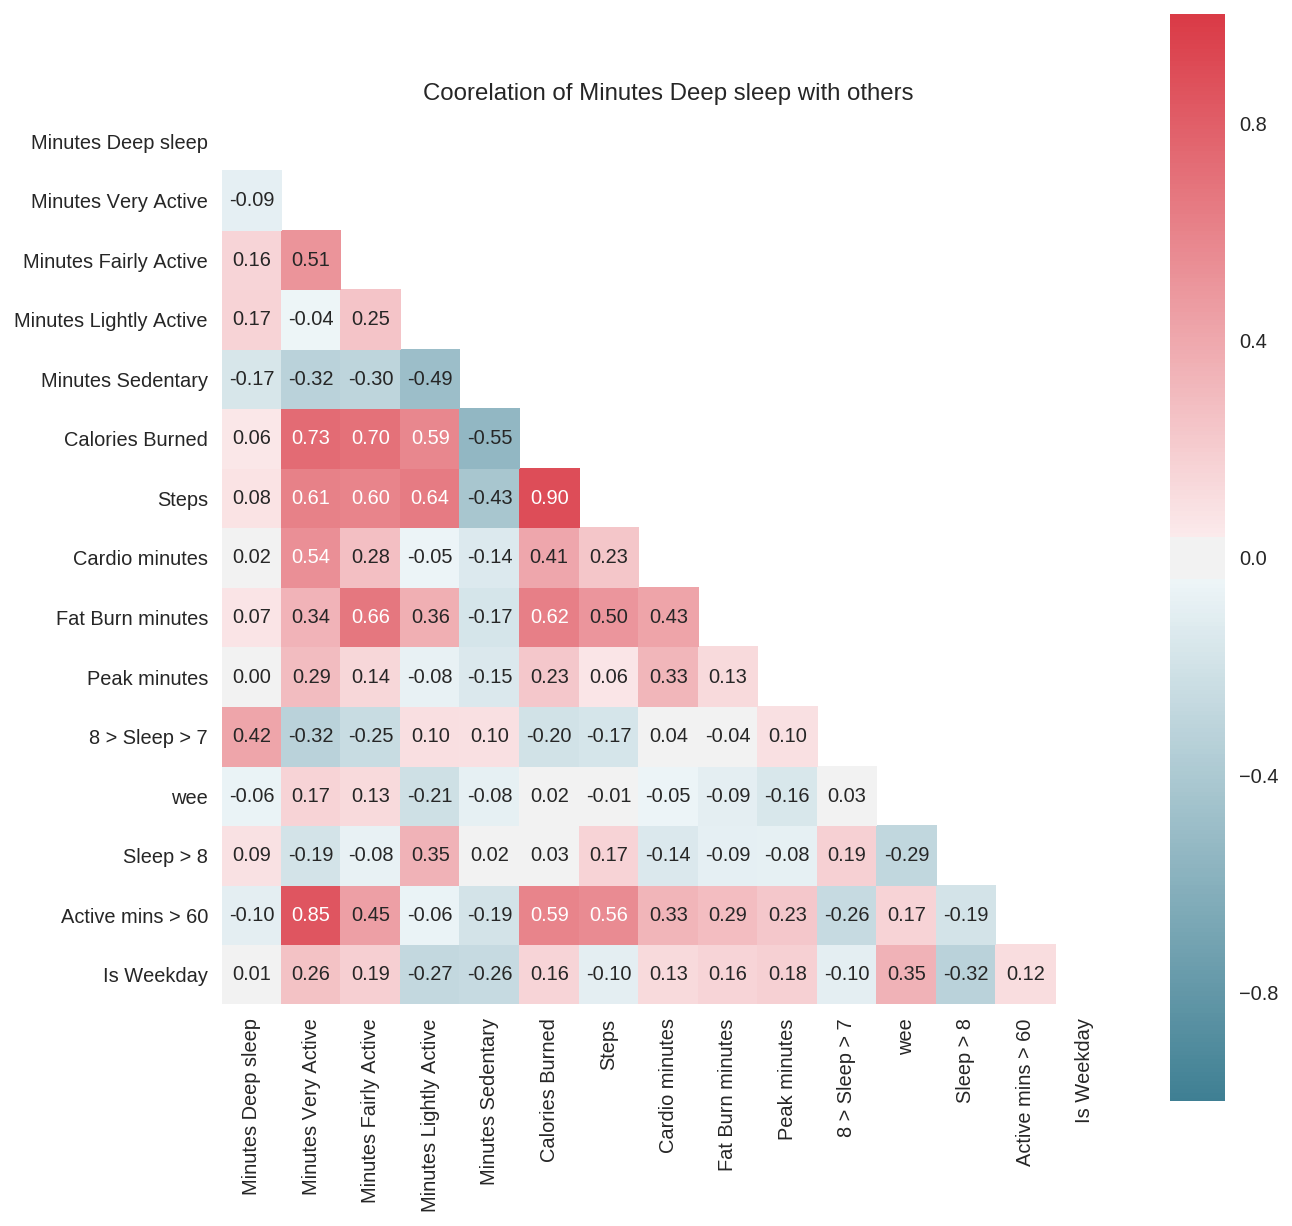

In [24]:
correlationOf="Minutes Deep sleep"
k = 15 #number of variables for heatmap
corrmat = sleepData[['Minutes Deep sleep', 'Minutes Very Active', 'Minutes Fairly Active', 'Minutes Lightly Active', 'Minutes Sedentary', 'Calories Burned', 'Steps',
          'Cardio minutes', 'Fat Burn minutes', 'Peak minutes',
          '8 > Sleep > 7', 'wee', 'Sleep > 8', 'Active mins > 60', 'Is Weekday']].corr()
#corrmat = sleepData.drop(['% Restorative sleep', 'Minutes Light sleep', 'Minutes REM sleep', '% Deep sleep', '% Light sleep', '% REM sleep', 'REM sleep count', 'Deep sleep count', 'Light sleep count'], axis=1).corr().abs()
#cols = corrmat.nlargest(k, correlationOf)[correlationOf].index
#corrdf_sleep = sleepData[cols]

plot_heatmap(corrmat, correlationOf, 'Coorelation of {} with others'.format(correlationOf), darkTheme=False)

## Machine Learning

Since we have some insights now on the activities and sleep. Let's see if we could use some of the basic ML techniques to see if there is a pattern to predict what are the ingredients for a decent sleep!

Though we have a handfulof data and vely less features, I don't expect to see some magic here. Will be repeating this once i have some more sleep data.

For now lets lay the basic template.

In [25]:
sleepData.head()

,Date,Day of Week,Is Weekday,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Sleep Start time,Sleep End time,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep,Day Label,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins,8 > Sleep > 7,Sleep > 7,Sleep > 8,Active mins > 50,Active mins > 60,wee
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-24,2018-06-24,7,False,True,1996,1690,3367,3.01,0.00,59.0,0,1377,47,2,14,362,-1,11.0,133.10892,14.0,89.20880,0.0,0.0,446.51352,284.0,92.0,379.0,0.0,2018-06-24T22:17:00.000,2018-06-25T05:28:30.000,431.0,56.0,2.0,244.0,26.0,79.0,6.0,52.0,25.0,13.0,57.0,19.0,Sun,False,22.5,5.5,11.0,32.0,135.0,True,True,False,False,False,True
2018-06-25,2018-06-25,1,True,False,2863,1685,8394,5.55,36.58,58.0,12,709,244,42,14,1361,-1,2.0,12.40518,94.0,514.11279,0.0,0.0,2311.92765,1326.0,95.0,333.0,0.0,2018-06-25T22:49:30.000,2018-06-26T05:16:30.000,387.0,75.0,3.0,214.0,27.0,44.0,7.0,54.0,30.0,20.0,56.0,12.0,Mon,False,23.0,5.5,12.0,32.0,119.0,False,False,False,False,False,True
2018-06-26,2018-06-26,2,True,False,3398,1683,13569,9.68,24.38,57.0,8,687,231,33,102,2004,-1,10.0,103.59112,187.0,1245.54876,0.0,0.0,2034.05724,1232.0,89.0,351.0,0.0,2018-06-26T22:25:30.000,2018-06-27T05:07:30.000,402.0,53.0,3.0,223.0,28.0,75.0,7.0,51.0,29.0,14.0,56.0,19.0,Tue,True,22.5,5.5,11.0,33.0,128.0,False,False,False,True,True,True
2018-06-27,2018-06-27,3,True,False,3442,1682,13337,9.33,33.53,57.0,11,665,243,30,100,2035,-1,11.0,114.28908,217.0,1310.46804,0.0,0.0,1986.03570,1187.0,97.0,365.0,0.0,2018-06-27T22:36:30.000,2018-06-28T05:24:00.000,407.0,66.0,4.0,197.0,32.0,102.0,10.0,42.0,32.0,17.0,49.0,26.0,Wed,True,23.0,5.5,8.0,43.0,168.0,False,False,False,True,True,True
2018-07-01,2018-07-01,7,False,True,1718,1681,155,0.09,0.00,58.0,0,1427,13,0,0,46,-1,0.0,0.00000,1.0,3.97018,0.0,0.0,233.77354,171.0,96.0,402.0,0.0,2018-07-01T22:34:00.000,2018-07-02T05:54:30.000,440.0,77.0,5.0,233.0,34.0,92.0,8.0,38.0,34.0,18.0,53.0,21.0,Sun,False,23.0,6.0,8.0,39.0,169.0,True,True,False,False,False,True


## Regression

In [0]:
from sklearn.model_selection import train_test_split

Let's build our training and test dataset

In [27]:
y = sleepData['Minutes Deep sleep']
X = sleepData[['Calories Burned', 'Steps', 'Elevation (Ft)', 'Floors', 'Minutes Lightly Active', 'Minutes Fairly Active', 'Minutes Very Active', 'Fat Burn minutes', 'Active exercise', 'Time in bed', 'Sleep Bucket', 'Day of Week']]
X.fillna(X.mean(), inplace=True)

#label encode the category values
X = pd.get_dummies(X, columns=['Day of Week', 'Sleep Bucket'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print('X shape: {}'.format(X.shape))
print('Y shape: {}'.format(y.shape))

X shape: (76, 29)
Y shape: (76,)


### Linear Regression

In [28]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
lr_y_pred = regr.predict(X_test)
                        
print("Mean squared error: %.2f"% mean_squared_error(y_test, lr_y_pred))
#coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regr.coef_))], axis = 1)
#coefficients

Mean squared error: 801.94


### XGboost

In [29]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgbR = XGBRegressor()
parameters = {'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07, 0.1],
              'max_depth': [3, 4, 5, 6],
              'min_child_weight': [1, 5, 10],
              'silent': [1],
              'n_estimators': [100, 300, 500],
              'seed': [1212]
             }

xgb_grid = GridSearchCV(xgbR, parameters, n_jobs = 5, verbose=True)
xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

y_pred = xgb_grid.predict(X_test)
print ("RMSE : ",mean_squared_error(y_test,y_pred))

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   10.8s


-0.1125234730323068
{'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'objective': 'reg:linear', 'seed': 1212, 'silent': 1}
RMSE :  365.11731179031017


[Parallel(n_jobs=5)]: Done 432 out of 432 | elapsed:   18.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


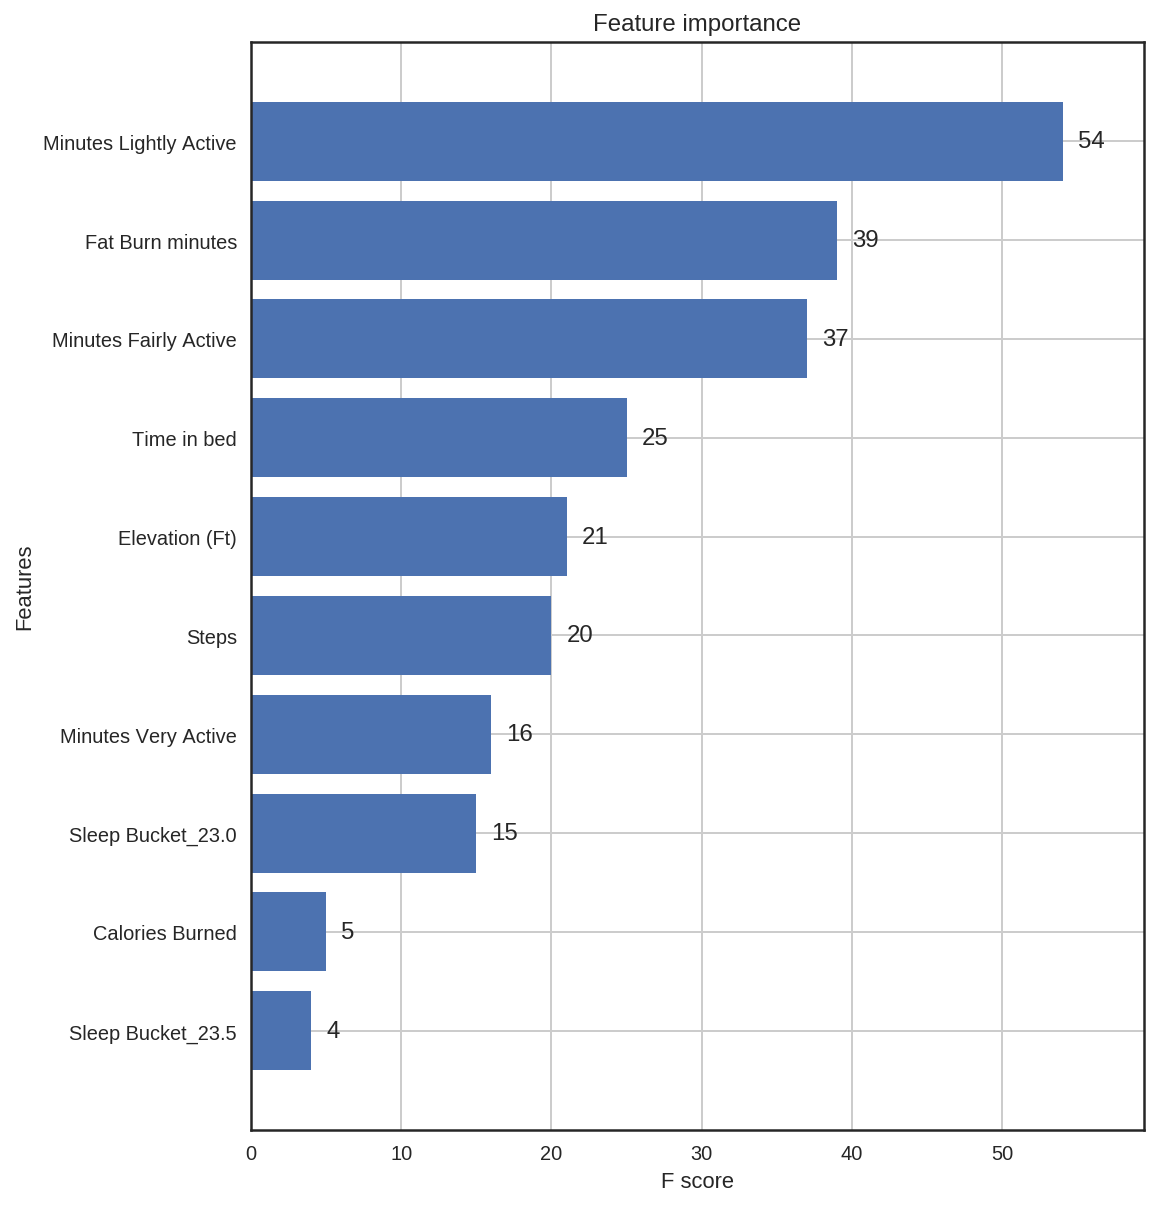

In [30]:
fig, ax = plt.subplots(figsize=(8,10))
xgb.plot_importance(xgb_grid.best_estimator_, height=0.8, ax=ax)
plt.show()
#y_pred = xgb_grid.predict(X_test)

### Classification

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import graphviz 



def trainAndPredict(classifier):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    print ("Accuracy : ",accuracy_score(y_test,y_pred)*100)
    print("Report : ",classification_report(y_test, y_pred))
    #print("Confusion Matrix: ",confusion_matrix(y_test, y_pred))
    return

def plotGraph(classifier):
    dot_data = tree.export_graphviz(classifier, out_file=None, 
                         feature_names=X.columns.values,  
                         class_names=['Yes', 'No'],                                
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = graphviz.Source(dot_data)  
    return graph

In [32]:
X = sleepData[['Day of Week', 'Calories Burned', 'Steps', 'Elevation (Ft)', 'Floors', 'Minutes Sedentary', 'Minutes Lightly Active', 'Minutes Fairly Active', 'Minutes Very Active', 'Fat Burn minutes', 'Active exercise', 'Time in bed']]
X.fillna(X.mean(), inplace=True)

Y = sleepData['% Restorative sleep'] > 35

print('X shape: {}'.format(X.shape))
print('Y shape: {}'.format(Y.shape))

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)
print('X_train shape: {}. X_test shape: {}'.format(X_train.shape, X_test.shape))

X shape: (76, 12)
Y shape: (76,)
X_train shape: (53, 12). X_test shape: (23, 12)


Accuracy :  34.78260869565217
Report :                precision    recall  f1-score   support

       False       0.38      0.42      0.40        12
        True       0.30      0.27      0.29        11

   micro avg       0.35      0.35      0.35        23
   macro avg       0.34      0.34      0.34        23
weighted avg       0.34      0.35      0.35        23



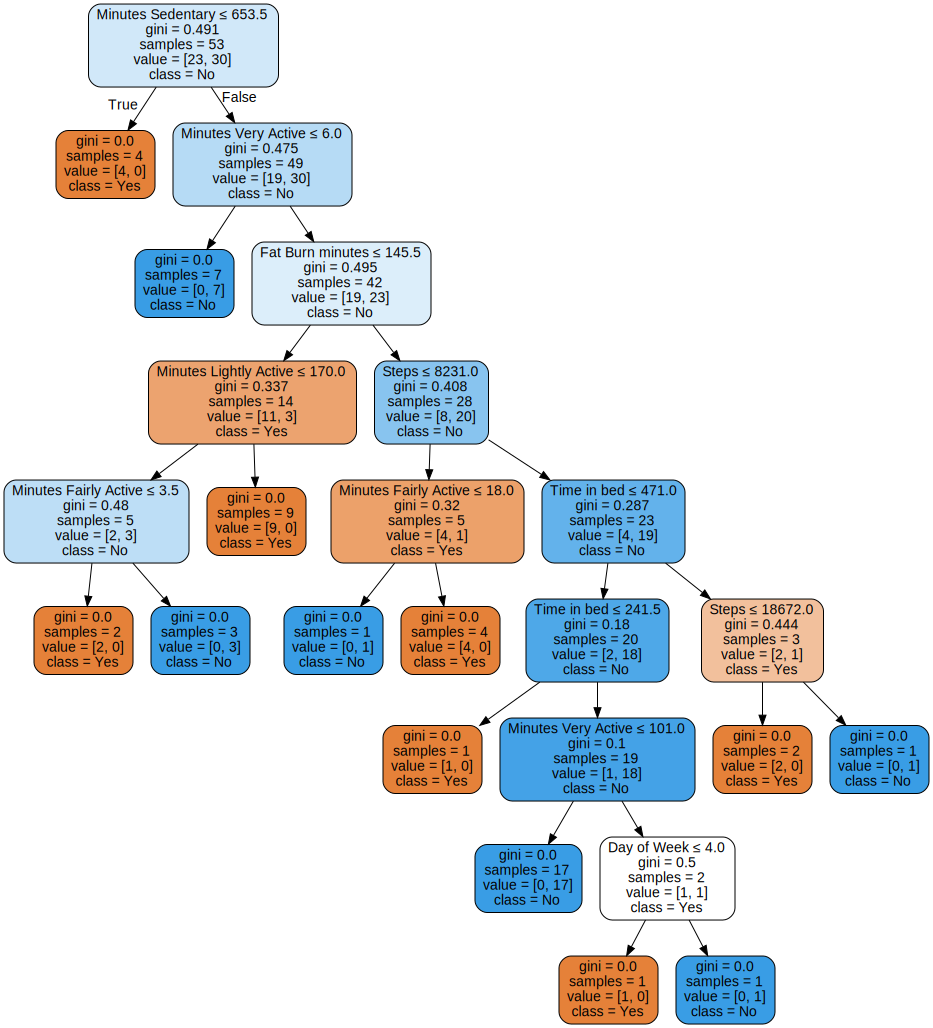

In [33]:
clf_gini_default = DecisionTreeClassifier(criterion = "gini")
trainAndPredict(clf_gini_default)
plotGraph(clf_gini_default)